In [ ]:
import os

# root_dir = r"C:\Users\User\Downloads"
# root_dir = r"C:\Users\linpo\Downloads"
# root_dir = r"C:\Users\PoYuLin\Downloads"
root_dir = r"D:\TAICA_FP"
os.makedirs(root_dir, exist_ok=True)

# Data Reorganize

In [29]:
import os
import zipfile

zip_files = [
    os.path.join(root_dir, "osfstorage-archive.zip"),
    os.path.join(root_dir, "HuashanMyo.zip"),
    os.path.join(root_dir, "Folkhalsan.zip")
]

for zip_path in zip_files:
    folder_name = os.path.splitext(os.path.basename(zip_path))[0]
    extract_path = os.path.join(root_dir, folder_name)
    os.makedirs(extract_path, exist_ok=True)

    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

    print(f"已解壓縮：{zip_path} → {extract_path}")

已解壓縮：/gpfs/home/pl2948/CV/Project/data/osfstorage-archive.zip → /gpfs/home/pl2948/CV/Project/data/osfstorage-archive
已解壓縮：/gpfs/home/pl2948/CV/Project/data/HuashanMyo.zip → /gpfs/home/pl2948/CV/Project/data/HuashanMyo
已解壓縮：/gpfs/home/pl2948/CV/Project/data/Folkhalsan.zip → /gpfs/home/pl2948/CV/Project/data/Folkhalsan


In [30]:
import os
import zipfile

folder_path = os.path.join(root_dir, "osfstorage-archive")

for file in sorted(os.listdir(folder_path)):
    if file.endswith('.zip'):
        zip_path = os.path.normcase(os.path.abspath(os.path.join(folder_path, file)))

        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(folder_path)
        # print(f"已解壓縮 {file}")

for fname in sorted(os.listdir(folder_path)):
    if not fname.lower().endswith('.zip'):
        continue
    fpath = os.path.abspath(os.path.join(folder_path, fname))
    os.remove(fpath)
    # print(f"已移除: {fname}")

print(f"已解壓縮並移除 {folder_path} 中的 zip 檔案")

已解壓縮並移除 /gpfs/home/pl2948/CV/Project/data/osfstorage-archive 中的 zip 檔案


# Image exploration

## HuashanMyo

- Adductor漏了兩塊沒有label
- 不是每個axial cut都有label
- Other資料夾裡面是label差太多不能共用的

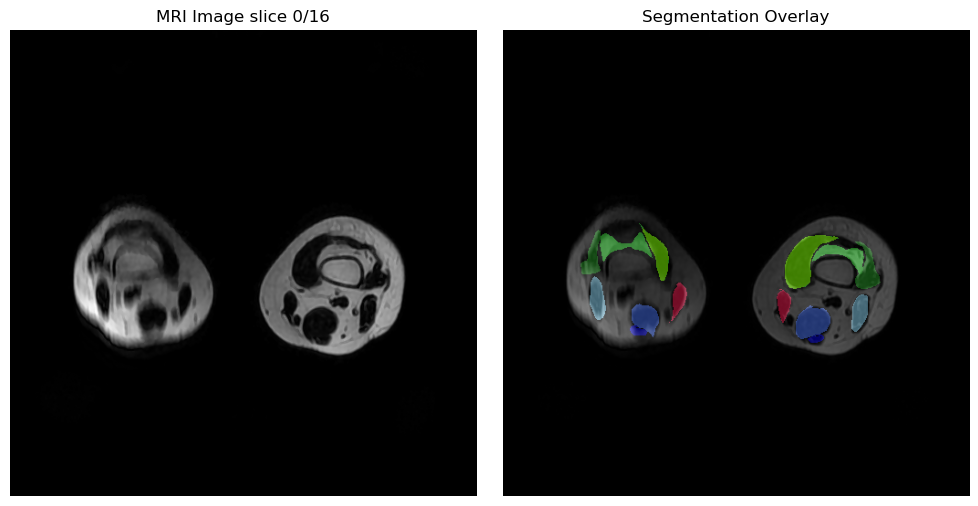

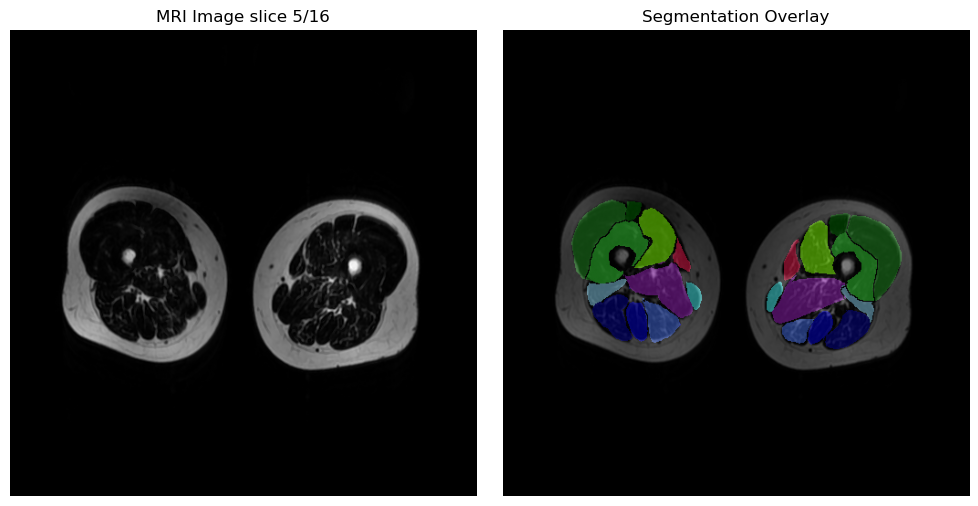

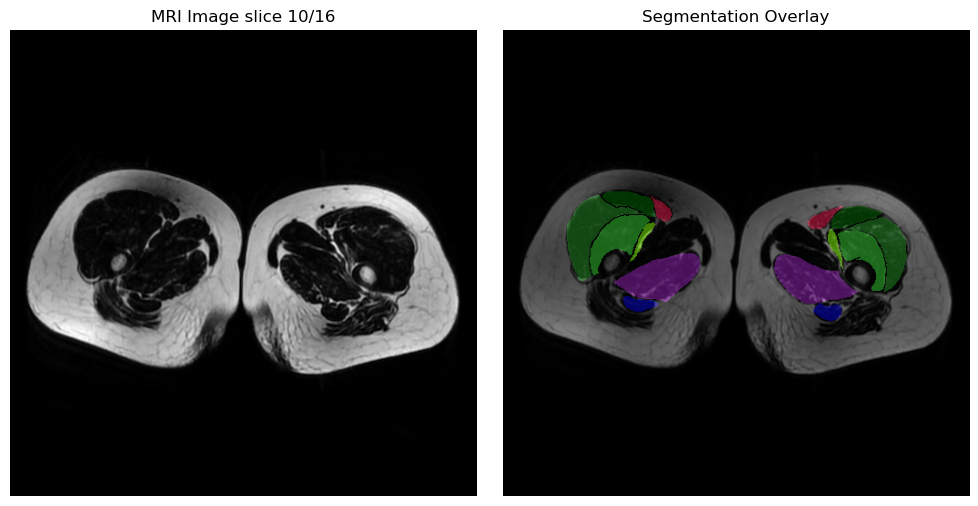

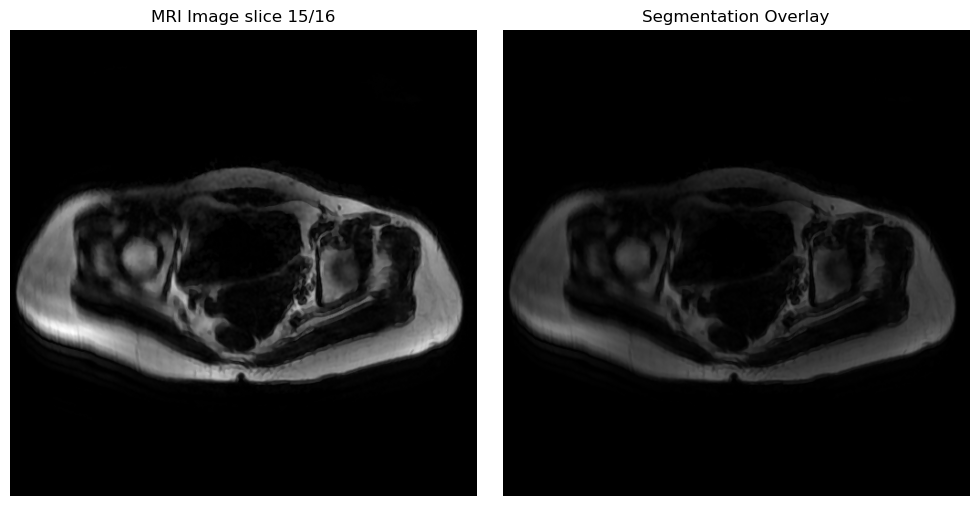

In [31]:
import SimpleITK as sitk
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import os

label_colors = [
    '#000000',  # 0: 背景 - 黑色
    '#e6194b',  # 1: sartorius 紅色
    '#006400',  # 2: rectus femoris 深綠色
    '#228B22',  # 3: vastus lateralis 中綠色
    '#32CD32',  # 4: vastus intermedius 淺綠色
    '#7CFC00',  # 5: vastus medialis 最淺綠色
    '#911eb4',  # 6: adductor magnus 紫色
    '#46f0f0',  # 7: gracilis 青色
    '#00008B',  # 8: biceps femoris long head 深藍色
    '#0000CD',  # 9: semitendinosus 中藍色
    '#4169E1',  # 10: semimembranosus 淺藍色
    '#87CEEB',  # 11: biceps femoris short head 最淺藍色
]

cmap = mcolors.ListedColormap(label_colors)
norm = mcolors.BoundaryNorm(boundaries=np.arange(14)-0.5, ncolors=13)

image_path = os.path.join(root_dir, "HuashanMyo", "HuashanMyo", "Water", "THIGH_009_0001.nii.gz")
image_path = os.path.join(root_dir, "HuashanMyo", "HuashanMyo", "T2", "THIGH_009_0003.nii.gz")
image_path = os.path.join(root_dir, "HuashanMyo", "HuashanMyo", "T1", "THIGH_009_0002.nii.gz")
image_path = os.path.join(root_dir, "HuashanMyo", "HuashanMyo", "STIR", "THIGH_009_0004.nii.gz")
image_path = os.path.join(root_dir, "HuashanMyo", "HuashanMyo", "Fat", "THIGH_009_0000.nii.gz")

label_path = os.path.join(root_dir, "HuashanMyo", "HuashanMyo", "Label", "THIGH_009.nii.gz")

image = sitk.ReadImage(image_path)
label = sitk.ReadImage(label_path)

image_array = sitk.GetArrayFromImage(image)
label_array = sitk.GetArrayFromImage(label)

for slice_index in range(0, image_array.shape[0], image_array.shape[0]//3):

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    axs[0].imshow(image_array[slice_index, :, :], cmap='gray')
    axs[0].set_title(f'MRI Image slice {slice_index}/{image_array.shape[0]}')
    axs[0].axis('off')

    axs[1].imshow(image_array[slice_index, :, :], cmap='gray')
    axs[1].imshow(label_array[slice_index, :, :], cmap=cmap, norm=norm, alpha=0.5)
    axs[1].set_title('Segmentation Overlay')
    axs[1].axis('off')

    plt.tight_layout()
    plt.show()

In [32]:
import os
import re
import SimpleITK as sitk

base_dir = os.path.join(root_dir, "HuashanMyo", "HuashanMyo")
pattern = re.compile(r"THIGH_(\d{3})(_[a-zA-Z0-9]+)?\.nii\.gz")

for i in range(1, 67):
    group_id = f"{i:03}"  
    group_files = []
    group_sizes = set()

    for root, _, files in os.walk(base_dir):
        for file in files:
            if pattern.match(file) and file.startswith(f"THIGH_{group_id}"):
                file_path = os.path.join(root, file)
                try:
                    image = sitk.ReadImage(file_path)
                    size = image.GetSize()
                    group_files.append((file, size))
                    group_sizes.add(size)
                except Exception as e:
                    print(f"讀取失敗: {file_path}, 錯誤: {e}")

    print(f"\n檔案組別: THIGH_{group_id}")
    if group_files:
        print(f"找到 {len(group_files)} 個檔案")
        if len(group_sizes) == 1:
            print("所有檔案的大小一致")
            print(f"  {group_id}: {group_sizes}")
        else:
            print("檔案大小不一致:")
            for file, size in group_files:
                print(f"  {file}: {size}")
    else:
        print("未找到符合條件的檔案")


檔案組別: THIGH_001
找到 6 個檔案
所有檔案的大小一致
  001: {(512, 512, 14)}

檔案組別: THIGH_002
找到 5 個檔案
所有檔案的大小一致
  002: {(512, 512, 14)}

檔案組別: THIGH_003
找到 5 個檔案
所有檔案的大小一致
  003: {(512, 512, 15)}

檔案組別: THIGH_004
找到 5 個檔案
所有檔案的大小一致
  004: {(512, 512, 14)}

檔案組別: THIGH_005
找到 5 個檔案
所有檔案的大小一致
  005: {(512, 512, 14)}

檔案組別: THIGH_006
找到 5 個檔案
所有檔案的大小一致
  006: {(512, 512, 15)}

檔案組別: THIGH_007
找到 5 個檔案
所有檔案的大小一致
  007: {(512, 512, 15)}

檔案組別: THIGH_008
找到 5 個檔案
所有檔案的大小一致
  008: {(512, 512, 16)}

檔案組別: THIGH_009
找到 6 個檔案
所有檔案的大小一致
  009: {(512, 512, 16)}

檔案組別: THIGH_010
找到 5 個檔案
所有檔案的大小一致
  010: {(512, 512, 14)}

檔案組別: THIGH_011
找到 5 個檔案
所有檔案的大小一致
  011: {(512, 512, 14)}

檔案組別: THIGH_012
找到 5 個檔案
所有檔案的大小一致
  012: {(512, 512, 15)}

檔案組別: THIGH_013
找到 5 個檔案
所有檔案的大小一致
  013: {(512, 512, 16)}

檔案組別: THIGH_014
找到 6 個檔案
所有檔案的大小一致
  014: {(512, 512, 14)}

檔案組別: THIGH_015
找到 5 個檔案
所有檔案的大小一致
  015: {(512, 512, 16)}

檔案組別: THIGH_016
找到 7 個檔案
檔案大小不一致:
  THIGH_016.nii.gz: (512, 512, 16)
  THIGH_016_others.nii.gz: (51

## Folkhalsan

- Series編號和前一組dataset不同
- 每個影像的大小不一致

In [33]:
import os

old_folder = os.path.join(root_dir, "Folkhalsan", "Folkhälsan")
new_folder = os.path.join(root_dir, "Folkhalsan", "Folkhalsan")

try:
    os.rename(old_folder, new_folder)
    print("資料夾重新命名成功")
except Exception as e:
    print("重新命名失敗:", e)

資料夾重新命名成功


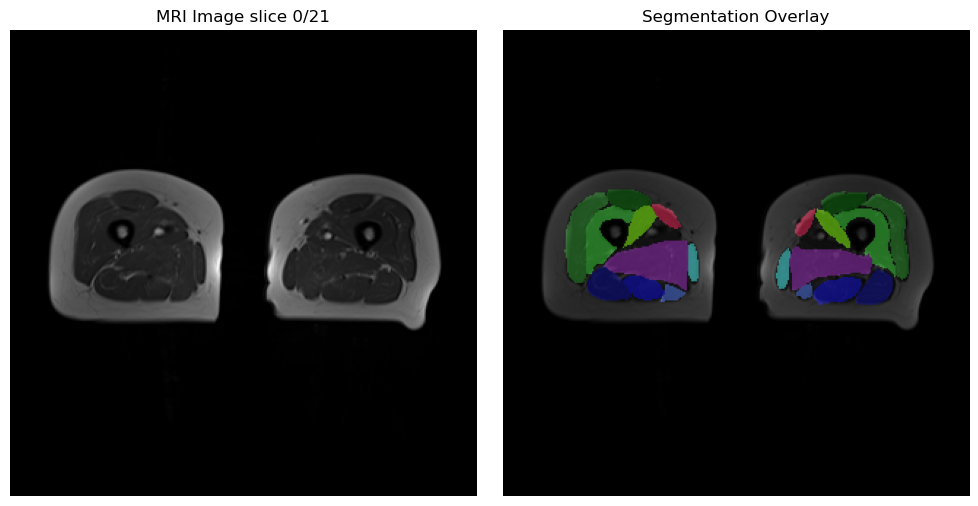

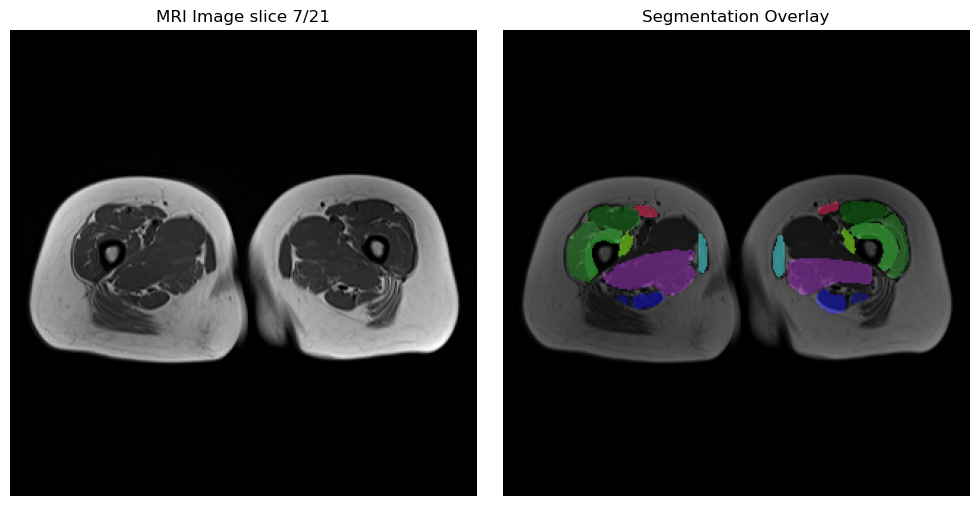

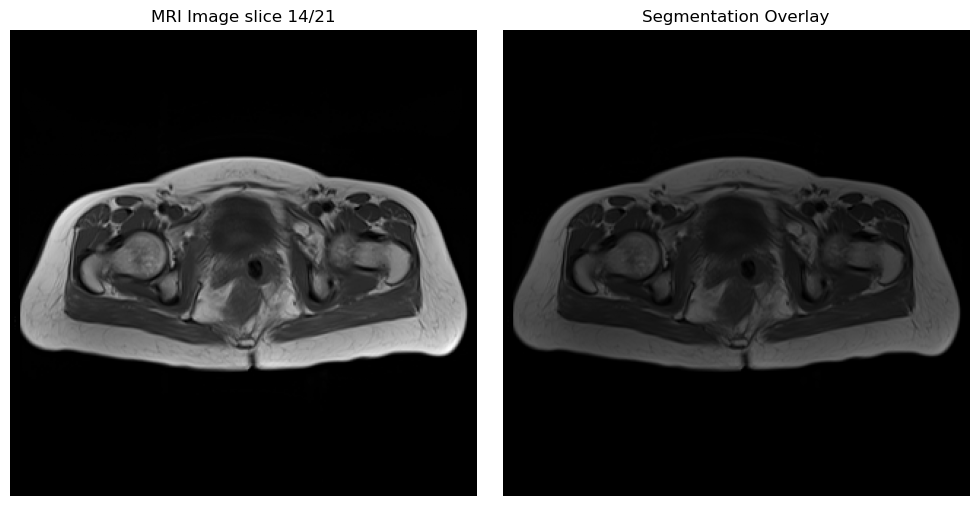

In [34]:
import SimpleITK as sitk
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import os

label_colors = [
    '#000000',  # 0: 背景 - 黑色
    '#e6194b',  # 1: sartorius 紅色
    '#006400',  # 2: rectus femoris 深綠色
    '#228B22',  # 3: vastus lateralis 中綠色
    '#32CD32',  # 4: vastus intermedius 淺綠色
    '#7CFC00',  # 5: vastus medialis 最淺綠色
    '#911eb4',  # 6: adductor magnus 紫色
    '#46f0f0',  # 7: gracilis 青色
    '#00008B',  # 8: biceps femoris long head 深藍色
    '#0000CD',  # 9: semitendinosus 中藍色
    '#4169E1',  # 10: semimembranosus 淺藍色
    '#87CEEB',  # 11: biceps femoris short head 最淺藍色
]

# 建立 colormap 和 normalization
cmap = mcolors.ListedColormap(label_colors)
norm = mcolors.BoundaryNorm(boundaries=np.arange(14)-0.5, ncolors=13)

# 讀取影像與標註
image_path = os.path.join(root_dir, "Folkhalsan", "Folkhalsan", "T1", "THIGH_101_0000.nii.gz")
# image_path = os.path.join(root_dir, "Folkhalsan", "Folkhalsan", "STIR", "THIGH_101_0001.nii.gz")

label_path = os.path.join(root_dir, "Folkhalsan", "Folkhalsan", "Label", "THIGH_101.nii.gz")

image = sitk.ReadImage(image_path)
label = sitk.ReadImage(label_path)

image_array = sitk.GetArrayFromImage(image)
label_array = sitk.GetArrayFromImage(label)

for slice_index in range(0, image_array.shape[0], image_array.shape[0]//3):

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    axs[0].imshow(image_array[slice_index, :, :], cmap='gray')
    axs[0].set_title(f'MRI Image slice {slice_index}/{image_array.shape[0]}')
    axs[0].axis('off')

    axs[1].imshow(image_array[slice_index, :, :], cmap='gray')
    axs[1].imshow(label_array[slice_index, :, :], cmap=cmap, norm=norm, alpha=0.5)
    axs[1].set_title('Segmentation Overlay')
    axs[1].axis('off')

    plt.tight_layout()
    plt.show()


In [35]:
import os
import re
import SimpleITK as sitk

base_dir = os.path.join(root_dir, "Folkhalsan", "Folkhalsan")
pattern = re.compile(r"THIGH_(\d{3})(_[a-zA-Z0-9]+)?\.nii\.gz")

for i in range(101, 127):
    group_id = f"{i:03}"  # 格式化為三位數，例如 001, 002
    group_files = []
    group_sizes = set()

    for root, _, files in os.walk(base_dir):
        for file in files:
            if pattern.match(file) and file.startswith(f"THIGH_{group_id}"):
                file_path = os.path.join(root, file)
                try:
                    image = sitk.ReadImage(file_path)
                    size = image.GetSize()
                    group_files.append((file, size))
                    group_sizes.add(size)
                except Exception as e:
                    print(f"讀取失敗: {file_path}, 錯誤: {e}")

    print(f"\n檔案組別: THIGH_{group_id}")
    if group_files:
        print(f"找到 {len(group_files)} 個檔案")
        if len(group_sizes) == 1:
            print("所有檔案的大小一致")
            print(f"  {group_id}: {group_sizes}")
        else:
            print("檔案大小不一致:")
            for file, size in group_files:
                print(f"  {file}: {size}")
    else:
        print("未找到符合條件的檔案")


檔案組別: THIGH_101
找到 3 個檔案
所有檔案的大小一致
  101: {(320, 320, 21)}

檔案組別: THIGH_102
找到 3 個檔案
所有檔案的大小一致
  102: {(512, 512, 36)}

檔案組別: THIGH_103
找到 3 個檔案
所有檔案的大小一致
  103: {(384, 282, 40)}

檔案組別: THIGH_104
找到 3 個檔案
所有檔案的大小一致
  104: {(320, 320, 21)}

檔案組別: THIGH_105
找到 3 個檔案
所有檔案的大小一致
  105: {(384, 348, 42)}

檔案組別: THIGH_106
找到 3 個檔案
所有檔案的大小一致
  106: {(512, 512, 23)}

檔案組別: THIGH_107
找到 3 個檔案
所有檔案的大小一致
  107: {(512, 448, 50)}

檔案組別: THIGH_108
找到 3 個檔案
所有檔案的大小一致
  108: {(320, 320, 23)}

檔案組別: THIGH_109
找到 3 個檔案
所有檔案的大小一致
  109: {(320, 320, 21)}

檔案組別: THIGH_110
找到 3 個檔案
所有檔案的大小一致
  110: {(256, 180, 15)}

檔案組別: THIGH_111
找到 3 個檔案
所有檔案的大小一致
  111: {(256, 180, 15)}

檔案組別: THIGH_112
找到 3 個檔案
所有檔案的大小一致
  112: {(512, 512, 45)}

檔案組別: THIGH_113
找到 3 個檔案
所有檔案的大小一致
  113: {(320, 320, 13)}

檔案組別: THIGH_114
找到 3 個檔案
所有檔案的大小一致
  114: {(480, 480, 60)}

檔案組別: THIGH_115
找到 3 個檔案
所有檔案的大小一致
  115: {(320, 320, 21)}

檔案組別: THIGH_116
找到 3 個檔案
所有檔案的大小一致
  116: {(320, 320, 21)}

檔案組別: THIGH_117
找到 3 個檔案
所有檔案的大小一致
  11

## osfstorage-archive

- 標註比較粗，只有四大類，在訓練的時候需要結構階層化
- stack1跟stack2解析度不同，不能疊起來
- 病患9資料夾名稱有問題要先更改

In [36]:
import SimpleITK as sitk
import matplotlib.pyplot as plt
import numpy as np

image_path1 = os.path.join(root_dir, "osfstorage-archive", "HV001_1", "ImageData", "HV001_1_FAT", "HV001_1_FAT_stack1.nii")
image_path2 = os.path.join(root_dir, "osfstorage-archive", "HV001_1", "ImageData", "HV001_1_FAT", "HV001_1_FAT_stack2.nii")

image1 = sitk.ReadImage(image_path1)
image2 = sitk.ReadImage(image_path2)

array1 = sitk.GetArrayFromImage(image1)
array2 = sitk.GetArrayFromImage(image2)

if array1.shape[1:] != array2.shape[1:]:
    print(f"影像的 x 和 y 軸大小不一致: {array1.shape[1:]} vs {array2.shape[1:]}")

影像的 x 和 y 軸大小不一致: (672, 672) vs (560, 560)


In [37]:
import os

old_folder = os.path.join(root_dir, "osfstorage-archive","HV009_1", "SegmentationMask")
new_folder = os.path.join(root_dir, "osfstorage-archive","HV009_1", "SegmentationMasks")

try:
    os.rename(old_folder, new_folder)
    print("資料夾重新命名成功")
except Exception as e:
    print("重新命名失敗:", e)

資料夾重新命名成功


In [39]:
import os

base_dir = os.path.join(root_dir, "osfstorage-archive")

for subfolder in sorted(os.listdir(base_dir)):
    subfolder_path = os.path.join(base_dir, subfolder)
    segmentation_masks_path = os.path.join(subfolder_path, "SegmentationMasks")

    if os.path.isdir(segmentation_masks_path):
        print(f"SegmentationMasks found in: {segmentation_masks_path}")

        mha_files = [f for f in sorted(os.listdir(segmentation_masks_path)) if f.endswith(".mha")]
        if mha_files:
            print("  .mha files:")
            for mha_file in mha_files:
                print(f"    {mha_file}")
        else:
            print("  No .mha files found.")
    else:
        print(f"No SegmentationMasks folder in: {subfolder_path}")

SegmentationMasks found in: /gpfs/home/pl2948/CV/Project/data/osfstorage-archive/HV001_1/SegmentationMasks
  .mha files:
    HV001_1_stack1_L_GR.mha
    HV001_1_stack1_L_HS.mha
    HV001_1_stack1_L_QF.mha
    HV001_1_stack1_L_SA.mha
    HV001_1_stack1_R_GR.mha
    HV001_1_stack1_R_HS.mha
    HV001_1_stack1_R_QF.mha
    HV001_1_stack1_R_SA.mha
    HV001_1_stack2_L_GR.mha
    HV001_1_stack2_L_HS.mha
    HV001_1_stack2_L_QF.mha
    HV001_1_stack2_L_SA.mha
    HV001_1_stack2_R_GR.mha
    HV001_1_stack2_R_HS.mha
    HV001_1_stack2_R_QF.mha
    HV001_1_stack2_R_SA.mha
SegmentationMasks found in: /gpfs/home/pl2948/CV/Project/data/osfstorage-archive/HV001_2/SegmentationMasks
  .mha files:
    HV001_2_stack1_L_GR.mha
    HV001_2_stack1_L_HS.mha
    HV001_2_stack1_L_QF.mha
    HV001_2_stack1_L_SA.mha
    HV001_2_stack1_R_GR.mha
    HV001_2_stack1_R_HS.mha
    HV001_2_stack1_R_QF.mha
    HV001_2_stack1_R_SA.mha
    HV001_2_stack2_L_GR.mha
    HV001_2_stack2_L_HS.mha
    HV001_2_stack2_L_QF.mha
  

In [41]:
import os
import SimpleITK as sitk
import numpy as np

base_dir = os.path.join(root_dir, "osfstorage-archive")

coarse_label_map = {"SA": 1, "QF": 2, "GR": 3, "HS": 4}

for subfolder in sorted(os.listdir(base_dir)):
    subfolder_path = os.path.join(base_dir, subfolder)
    segmentation_masks_path = os.path.join(subfolder_path, "SegmentationMasks")

    if not os.path.isdir(segmentation_masks_path):
        continue

    print(f"Processing SegmentationMasks in: {segmentation_masks_path}")

    mha_files = [f for f in sorted(os.listdir(segmentation_masks_path)) if f.endswith(".mha")]
    if not mha_files:
        print("  No .mha files found.")
        continue

    file_groups = {}
    for mha_file in mha_files:
        prefix = "_".join(mha_file.split("_")[:3])  # 取前綴，例如 HV001_1_stack1
        if prefix not in file_groups:
            file_groups[prefix] = []
        file_groups[prefix].append(mha_file)

    for prefix, files in file_groups.items():
        print(f"  Combining files for prefix: {prefix}")

        combined = None
        reference_img = None

        for file in files:
            file_path = os.path.join(segmentation_masks_path, file)
            for key, label in coarse_label_map.items():
                if f"_{key}" in file:
                    img = sitk.ReadImage(file_path)
                    arr = sitk.GetArrayFromImage(img)

                    if combined is None:
                        combined = np.zeros_like(arr, dtype=np.uint8)
                        reference_img = img

                    combined[arr > 0] = label
                    break

        if combined is not None and reference_img is not None:
            output_path = os.path.join(segmentation_masks_path, f"{prefix}.nii.gz")
            out_img = sitk.GetImageFromArray(combined)
            out_img.CopyInformation(reference_img)
            sitk.WriteImage(out_img, output_path)
            print(f"    Saved combined file: {output_path}")

Processing SegmentationMasks in: /gpfs/home/pl2948/CV/Project/data/osfstorage-archive/HV001_1/SegmentationMasks
  Combining files for prefix: HV001_1_stack1
    Saved combined file: /gpfs/home/pl2948/CV/Project/data/osfstorage-archive/HV001_1/SegmentationMasks/HV001_1_stack1.nii.gz
  Combining files for prefix: HV001_1_stack2
    Saved combined file: /gpfs/home/pl2948/CV/Project/data/osfstorage-archive/HV001_1/SegmentationMasks/HV001_1_stack2.nii.gz
Processing SegmentationMasks in: /gpfs/home/pl2948/CV/Project/data/osfstorage-archive/HV001_2/SegmentationMasks
  Combining files for prefix: HV001_2_stack1
    Saved combined file: /gpfs/home/pl2948/CV/Project/data/osfstorage-archive/HV001_2/SegmentationMasks/HV001_2_stack1.nii.gz
  Combining files for prefix: HV001_2_stack2
    Saved combined file: /gpfs/home/pl2948/CV/Project/data/osfstorage-archive/HV001_2/SegmentationMasks/HV001_2_stack2.nii.gz
Processing SegmentationMasks in: /gpfs/home/pl2948/CV/Project/data/osfstorage-archive/HV001_

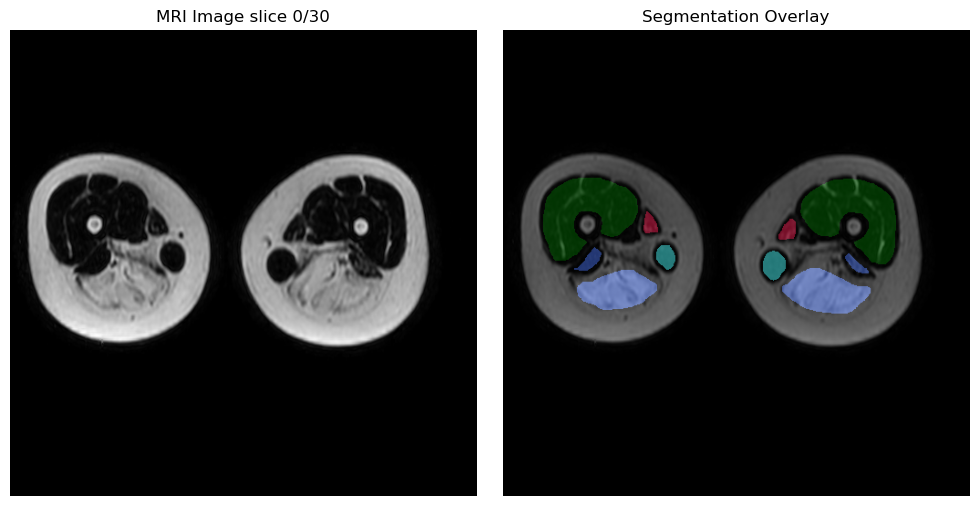

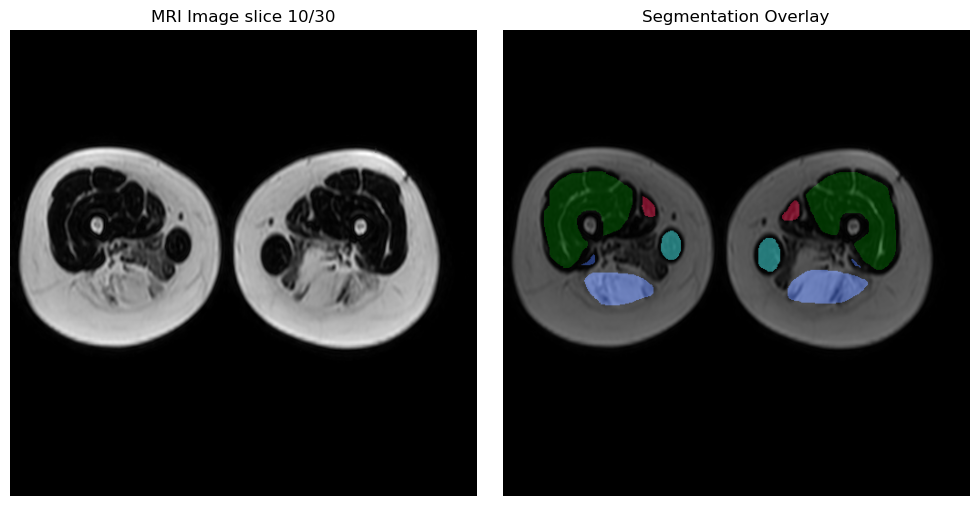

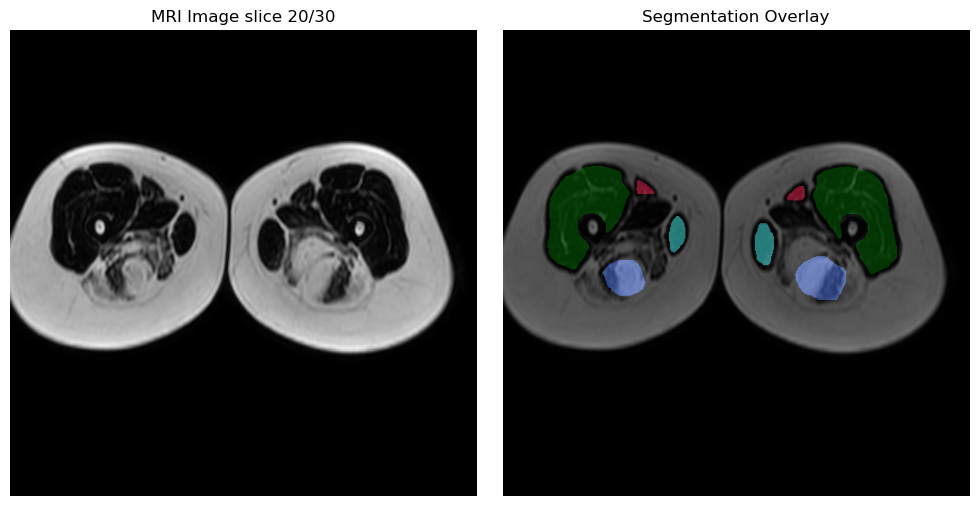

In [42]:
import SimpleITK as sitk
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import os

label_colors = [
    '#000000',  # 0: 背景 - 黑色
    '#e6194b',  # 1: sartorius 紅色
    '#006400',  # 2: quadriceps femoris 深綠色 (對應 2rectus femoris, 3 vastus lateralis, 4 vastus intermedius, 5 vastus medialis)
    '#46f0f0',  # 3: gracilis 青色
    '#4169E1',  # 4: hamstring 淺藍色 (biceps femoris long head 8, semitendinosus 9, semimembranosus 10, biceps femoris short head 11)
]

cmap = mcolors.ListedColormap(label_colors)
norm = mcolors.BoundaryNorm(boundaries=np.arange(14)-0.5, ncolors=13)

# 讀取影像與標註
image_path = os.path.join(root_dir, "osfstorage-archive", "HV001_1", "ImageData", "HV001_1_FAT", "HV001_1_FAT_stack1.nii")
label_path = os.path.join(root_dir, "osfstorage-archive", "HV001_1", "SegmentationMasks", "HV001_1_stack1.nii.gz")

image_path = os.path.join(root_dir, "osfstorage-archive", "HV001_2", "ImageData", "HV001_2_FAT", "HV001_2_FAT_stack1.nii")
label_path = os.path.join(root_dir, "osfstorage-archive", "HV001_2", "SegmentationMasks", "HV001_2_stack1.nii.gz")

image_path = os.path.join(root_dir, "osfstorage-archive", "HV015_1", "ImageData", "HV015_1_FAT", "HV015_1_FAT_stack2.nii")
label_path = os.path.join(root_dir, "osfstorage-archive", "HV015_1", "SegmentationMasks", "HV015_1_stack2.nii.gz")

image_path = os.path.join(root_dir, "osfstorage-archive", "P002_1", "ImageData", "P002_1_FAT", "P002_1_FAT_stack2.nii")
label_path = os.path.join(root_dir, "osfstorage-archive", "P002_1", "SegmentationMasks", "P002_1_stack2.nii.gz")


image = sitk.ReadImage(image_path)
label = sitk.ReadImage(label_path)

image_array = sitk.GetArrayFromImage(image)
label_array = sitk.GetArrayFromImage(label)

for slice_index in range(0, image_array.shape[0], image_array.shape[0]//3):

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    axs[0].imshow(image_array[slice_index, :, :], cmap='gray')
    axs[0].set_title(f'MRI Image slice {slice_index}/{image_array.shape[0]}')
    axs[0].axis('off')

    axs[1].imshow(image_array[slice_index, :, :], cmap='gray')
    axs[1].imshow(label_array[slice_index, :, :], cmap=cmap, norm=norm, alpha=0.5)
    axs[1].set_title('Segmentation Overlay')
    axs[1].axis('off')

    plt.tight_layout()
    plt.show()


# Split a test dataset

## Curate metadata raw

In [43]:
import pandas as pd

metadata = pd.read_csv(os.path.join(root_dir, "MRI_metadata.csv"))

display(metadata)
print(metadata.columns)

Dataset MRI sample Phenotype    Ethnicity Gender Age FAT WATER   T1  \
0      HuashanMyo  THIGH_001    LGMDR1  Han Chinese      M  29   ✓     ✓    ✓   
1      HuashanMyo  THIGH_002   Control  Han Chinese      M  32   ✓     ✓    ✓   
2      HuashanMyo  THIGH_003    LGMDR2  Han Chinese      F  31   ✓     ✓    ✓   
3      HuashanMyo  THIGH_004    LGMDR2  Han Chinese      M  42   ✓     ✓    ✓   
4      HuashanMyo  THIGH_005    LGMDR2  Han Chinese      M  56   ✓     ✓    ✓   
..            ...        ...       ...          ...    ...  ..  ..   ...  ...   
113  MyoSegmenTUM    HV015_1   Control      Germans      M  41   ✓     ✓  NaN   
114  MyoSegmenTUM     P001_1       DM2      Germans      M  52   ✓     ✓  NaN   
115  MyoSegmenTUM     P002_1    LGMDR1      Germans      F  52   ✓     ✓  NaN   
116  MyoSegmenTUM     P003_1       ALS      Germans      M  41   ✓     ✓  NaN   
117  MyoSegmenTUM     P004_1       DM2      Germans      F  66   ✓     ✓  NaN   

      T2 STIR  
0      ✓    ✓  
1      ✓  NaN  
2      ✓  NaN  
3      ✓  NaN  
4      ✓  NaN  
..   ...  ...  
113  NaN  NaN  
114  NaN  NaN  
115  NaN  NaN  
116  NaN  NaN  
117  NaN  NaN  

[118 rows x 11 columns]

Index(['Dataset', 'MRI sample', 'Phenotype', 'Ethnicity', 'Gender', 'Age',
       'FAT', 'WATER', 'T1', 'T2', 'STIR'],
      dtype='object')


In [44]:
import os
import pandas as pd

base_dir_huashan = os.path.join(root_dir, "HuashanMyo", "HuashanMyo")
subfolders_huashan = ['Fat', 'Label', 'Others', 'STIR', 'T1', 'T2', 'Water']

base_dir_folkhalsan = os.path.join(root_dir, "Folkhalsan", "Folkhalsan")
subfolders_folkhalsan = ['Label', 'STIR', 'T1']

base_dir_myoSegmenTUM = os.path.join(root_dir, "osfstorage-archive")

new_data = []

for _, row in metadata.iterrows():
    dataset = row['Dataset']
    mri_sample = row['MRI sample']

    if dataset == 'HuashanMyo':
        for subfolder in subfolders_huashan:
            folder_path = os.path.join(base_dir_huashan, subfolder)

            for file in sorted(os.listdir(folder_path)):
                if file.startswith(mri_sample) and file.endswith('.nii.gz'):
                    file_path = os.path.join(subfolder, file)

                    if subfolder in ['Fat', 'STIR', 'T1', 'T2', 'Water']:
                        if '_' in file[len(mri_sample):]:  # 檢查是否有 "_0003" 之類的後綴
                            image_file = os.path.join("HuashanMyo", "HuashanMyo", file_path)
                            label_file = os.path.join("HuashanMyo", "HuashanMyo", 'Label', f"{mri_sample}.nii.gz")
                            image_type = subfolder
                    elif subfolder == 'Others':
                        if '_' in file[len(mri_sample):]:
                            image_file = os.path.join("HuashanMyo", "HuashanMyo", file_path)
                            label_file = os.path.join("HuashanMyo", "HuashanMyo", 'Others', f"{mri_sample}_others.nii.gz")

                            suffix = file.split("_")[-1].split(".")[0]  # 取得 _0001 的部分
                            if suffix == "0001":
                                image_type = "Water"
                            elif suffix == "0003":
                                image_type = "T2"
                            elif suffix == "0002":
                                image_type = "T1"
                            elif suffix == "0004":
                                image_type = "STIR"
                            elif suffix == "0000":
                                image_type = "Fat"

                    new_data.append({
                        'Dataset': row['Dataset'],
                        'MRI sample': row['MRI sample'],
                        'Phenotype': row['Phenotype'],
                        'Ethnicity': row['Ethnicity'],
                        'Gender': row['Gender'],
                        'Age': row['Age'],
                        'MRI Sequence': image_type,
                        'image_file': image_file,
                        'segmentation_file': label_file
                    })

    elif dataset == 'Folkhalsan':
        for subfolder in subfolders_folkhalsan:
            folder_path = os.path.join(base_dir_folkhalsan, subfolder)

            for file in sorted(os.listdir(folder_path)):
                if file.startswith(mri_sample) and file.endswith('.nii.gz'):
                    file_path = os.path.join(subfolder, file)

                    if subfolder in ['STIR', 'T1']:
                        if '_' in file[len(mri_sample):]:  # 檢查是否有 "_0003" 之類的後綴
                            image_file = os.path.join("Folkhalsan", "Folkhalsan", file_path)
                            label_file = os.path.join("Folkhalsan", "Folkhalsan", 'Label', f"{mri_sample}.nii.gz")
                            image_type = subfolder

                    new_data.append({
                        'Dataset': row['Dataset'],
                        'MRI sample': row['MRI sample'],
                        'Phenotype': row['Phenotype'],
                        'Ethnicity': row['Ethnicity'],
                        'Gender': row['Gender'],
                        'Age': row['Age'],
                        'MRI Sequence': image_type,
                        'image_file': image_file,
                        'segmentation_file': label_file
                    })

    elif dataset == 'MyoSegmenTUM':
        for subfolder in sorted(os.listdir(base_dir_myoSegmenTUM)):
            if subfolder.endswith("__MACOSX"):
                 continue
            subfolder_path = os.path.join(base_dir_myoSegmenTUM, subfolder)
            if not os.path.isdir(subfolder_path):
                continue
            # segmentation_masks_path = os.path.join(subfolder_path, "SegmentationMasks")
            for imgfolder in sorted(os.listdir(os.path.join(subfolder_path, "ImageData"))):
                # if not os.path.isdir(imgfolder_path):
                #     continue
                if imgfolder == ".DS_Store":  # 跳過 .DS_Store 檔案
                        continue
                imgfolder_path = os.path.join(subfolder_path, "ImageData", imgfolder)

                for file in sorted(os.listdir(imgfolder_path)):
                    if file.startswith(mri_sample) and file.endswith('.nii'):
                        image_file = os.path.join("osfstorage-archive", subfolder, "ImageData", imgfolder, file)
                        suffix = file.split("_")[-1].split(".")[0]
                        image_type = file.split("_")[2]
                        label_file = os.path.join("osfstorage-archive", subfolder, "SegmentationMasks", f"{mri_sample}_{suffix}.nii.gz")
                        
                        new_data.append({
                            'Dataset': row['Dataset'],
                            'MRI sample': row['MRI sample'],
                            'Phenotype': row['Phenotype'],
                            'Ethnicity': row['Ethnicity'],
                            'Gender': row['Gender'],
                            'Age': row['Age'],
                            'MRI Sequence': image_type,
                            'image_file': image_file,
                            'segmentation_file': label_file
                        })


new_df = pd.DataFrame(new_data)

output_csv_path = os.path.join(root_dir, "combined_dataset.csv")
new_df.to_csv(output_csv_path, index=False)
print(f"新資料集已儲存至 {output_csv_path}")

新資料集已儲存至 /gpfs/home/pl2948/CV/Project/data/combined_dataset.csv


## Remove strange files

In [45]:
import pandas as pd

new_df = pd.read_csv(os.path.join(root_dir, "combined_dataset.csv"))

display(new_df)
print(new_df.columns)

Dataset MRI sample Phenotype    Ethnicity Gender Age MRI Sequence  \
0      HuashanMyo  THIGH_001    LGMDR1  Han Chinese      M  29          Fat   
1      HuashanMyo  THIGH_001    LGMDR1  Han Chinese      M  29          Fat   
2      HuashanMyo  THIGH_001    LGMDR1  Han Chinese      M  29         STIR   
3      HuashanMyo  THIGH_001    LGMDR1  Han Chinese      M  29           T1   
4      HuashanMyo  THIGH_001    LGMDR1  Han Chinese      M  29           T2   
..            ...        ...       ...          ...    ...  ..          ...   
574  MyoSegmenTUM     P004_1       DM2      Germans      F  66  FATFRACTION   
575  MyoSegmenTUM     P004_1       DM2      Germans      F  66  FATFRACTION   
576  MyoSegmenTUM     P004_1       DM2      Germans      F  66        WATER   
577  MyoSegmenTUM     P004_1       DM2      Germans      F  66        WATER   
578  MyoSegmenTUM     P004_1       DM2      Germans      F  66        WATER   

                                            image_file  \
0      HuashanMyo/HuashanMyo/Fat/THIGH_001_0000.nii.gz   
1      HuashanMyo/HuashanMyo/Fat/THIGH_001_0000.nii.gz   
2     HuashanMyo/HuashanMyo/STIR/THIGH_001_0004.nii.gz   
3       HuashanMyo/HuashanMyo/T1/THIGH_001_0002.nii.gz   
4       HuashanMyo/HuashanMyo/T2/THIGH_001_0003.nii.gz   
..                                                 ...   
574  osfstorage-archive/P004_1/ImageData/P004_1_FAT...   
575  osfstorage-archive/P004_1/ImageData/P004_1_FAT...   
576  osfstorage-archive/P004_1/ImageData/P004_1_WAT...   
577  osfstorage-archive/P004_1/ImageData/P004_1_WAT...   
578  osfstorage-archive/P004_1/ImageData/P004_1_WAT...   

                                     segmentation_file  
0         HuashanMyo/HuashanMyo/Label/THIGH_001.nii.gz  
1         HuashanMyo/HuashanMyo/Label/THIGH_001.nii.gz  
2         HuashanMyo/HuashanMyo/Label/THIGH_001.nii.gz  
3         HuashanMyo/HuashanMyo/Label/THIGH_001.nii.gz  
4         HuashanMyo/HuashanMyo/Label/THIGH_001.nii.gz  
..                                                 ...  
574  osfstorage-archive/P004_1/SegmentationMasks/P0...  
575  osfstorage-archive/P004_1/SegmentationMasks/P0...  
576  osfstorage-archive/P004_1/SegmentationMasks/P0...  
577  osfstorage-archive/P004_1/SegmentationMasks/P0...  
578  osfstorage-archive/P004_1/SegmentationMasks/P0...  

[579 rows x 9 columns]

Index(['Dataset', 'MRI sample', 'Phenotype', 'Ethnicity', 'Gender', 'Age',
       'MRI Sequence', 'image_file', 'segmentation_file'],
      dtype='object')


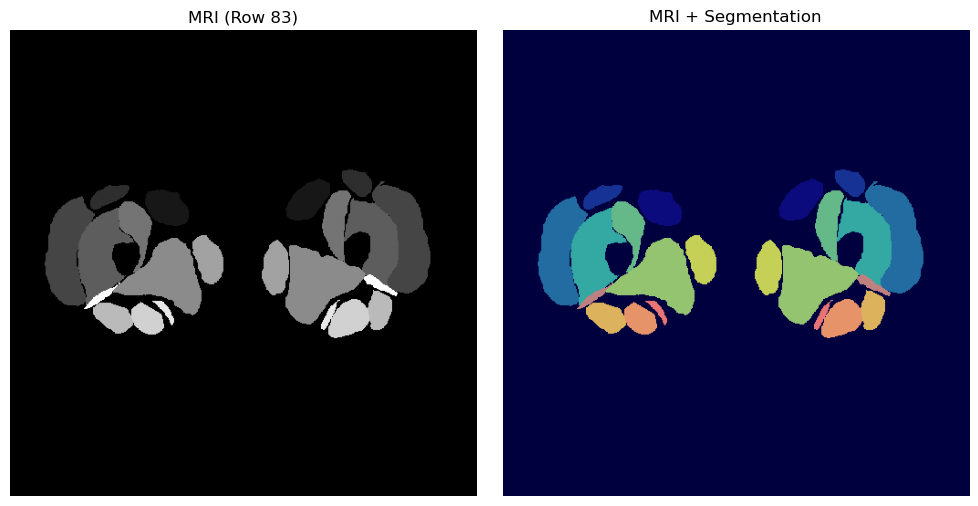

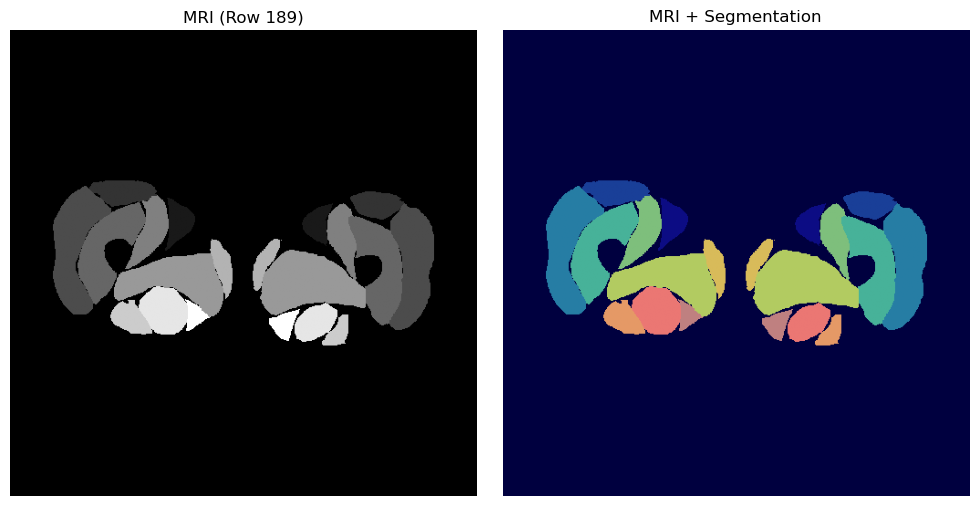

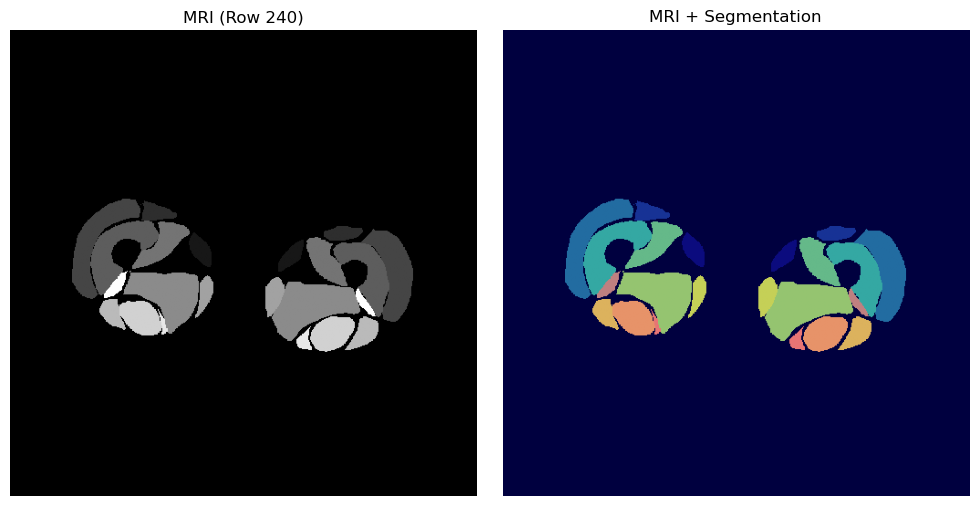

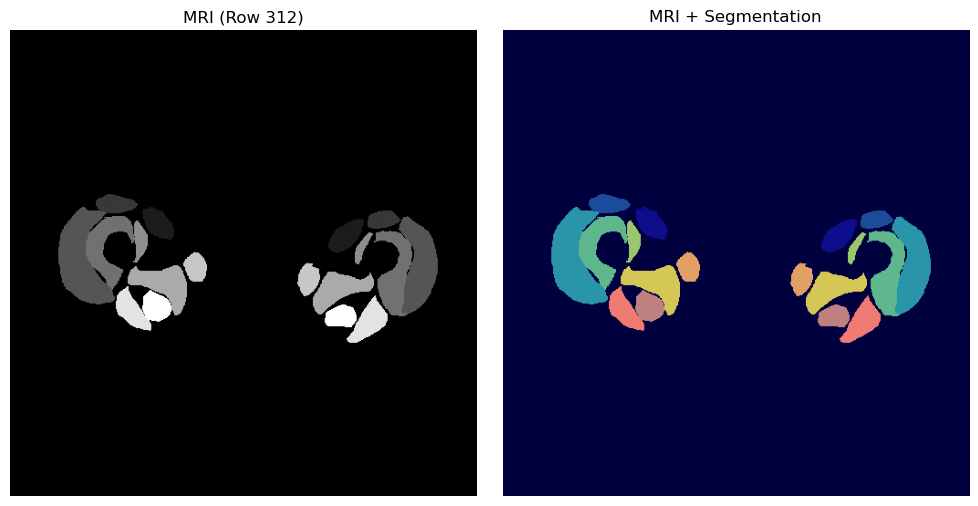

In [46]:
import os
import SimpleITK as sitk
import matplotlib.pyplot as plt
import numpy as np

for index, row in new_df.iterrows():
    image_path = os.path.join(root_dir, row['image_file'])
    segmentation_path = os.path.join(root_dir, row['segmentation_file'])

    # 檢查檔案是否存在
    if not os.path.exists(image_path):
        print(f"Image file not found: {image_path}")
        continue
    if not os.path.exists(segmentation_path):
        print(f"Segmentation file not found: {segmentation_path}")
        continue

    if index in [83, 189, 240, 312]: #這幾張混進奇怪的東西，不是真正的MRI
        image = sitk.ReadImage(image_path)
        segmentation = sitk.ReadImage(segmentation_path)

        image_array = sitk.GetArrayFromImage(image)
        segmentation_array = sitk.GetArrayFromImage(segmentation)

        z_middle = image_array.shape[0] // 2
        image_slice = image_array[z_middle, :, :]
        segmentation_slice = segmentation_array[z_middle, :, :]

        fig, axs = plt.subplots(1, 2, figsize=(10, 5))

        axs[0].imshow(image_slice, cmap='gray')
        axs[0].set_title(f'MRI (Row {index})')
        axs[0].axis('off')

        axs[1].imshow(image_slice, cmap='gray')
        axs[1].imshow(segmentation_slice, cmap='jet', alpha=0.5) 
        axs[1].set_title('MRI + Segmentation')
        axs[1].axis('off')

        plt.tight_layout()
        plt.show()

In [47]:
rows_to_remove = [83, 189, 240, 312]
display(new_df.iloc[rows_to_remove])

new_df = new_df.drop(rows_to_remove)

output_csv_path = os.path.join(root_dir, "combined_dataset.csv")
new_df.to_csv(output_csv_path, index=False)

print(f"已移除指定行，更新後的資料集已儲存至 {output_csv_path}")

Dataset MRI sample Phenotype    Ethnicity Gender Age MRI Sequence  \
83   HuashanMyo  THIGH_016    LGMDR2  Han Chinese      M  24         STIR   
189  HuashanMyo  THIGH_036    LGMDR2  Han Chinese      M  34         STIR   
240  HuashanMyo  THIGH_046    LGMDR2  Han Chinese      M  36           T2   
312  HuashanMyo  THIGH_060    LGMDR1  Han Chinese      M  24           T2   

                                            image_file  \
83   HuashanMyo/HuashanMyo/Others/THIGH_016_others....   
189  HuashanMyo/HuashanMyo/Others/THIGH_036_others....   
240  HuashanMyo/HuashanMyo/Others/THIGH_046_others....   
312  HuashanMyo/HuashanMyo/Others/THIGH_060_others....   

                                     segmentation_file  
83   HuashanMyo/HuashanMyo/Others/THIGH_016_others....  
189  HuashanMyo/HuashanMyo/Others/THIGH_036_others....  
240  HuashanMyo/HuashanMyo/Others/THIGH_046_others....  
312  HuashanMyo/HuashanMyo/Others/THIGH_060_others....

已移除指定行，更新後的資料集已儲存至 /gpfs/home/pl2948/CV/Project/data/combined_dataset.csv


## Patient level test dataset selection

## train test split

In [48]:
import pandas as pd

new_df = pd.read_csv(os.path.join(root_dir, "combined_dataset.csv"))

display(new_df)
print(new_df.columns)

Dataset MRI sample Phenotype    Ethnicity Gender Age MRI Sequence  \
0      HuashanMyo  THIGH_001    LGMDR1  Han Chinese      M  29          Fat   
1      HuashanMyo  THIGH_001    LGMDR1  Han Chinese      M  29          Fat   
2      HuashanMyo  THIGH_001    LGMDR1  Han Chinese      M  29         STIR   
3      HuashanMyo  THIGH_001    LGMDR1  Han Chinese      M  29           T1   
4      HuashanMyo  THIGH_001    LGMDR1  Han Chinese      M  29           T2   
..            ...        ...       ...          ...    ...  ..          ...   
570  MyoSegmenTUM     P004_1       DM2      Germans      F  66  FATFRACTION   
571  MyoSegmenTUM     P004_1       DM2      Germans      F  66  FATFRACTION   
572  MyoSegmenTUM     P004_1       DM2      Germans      F  66        WATER   
573  MyoSegmenTUM     P004_1       DM2      Germans      F  66        WATER   
574  MyoSegmenTUM     P004_1       DM2      Germans      F  66        WATER   

                                            image_file  \
0      HuashanMyo/HuashanMyo/Fat/THIGH_001_0000.nii.gz   
1      HuashanMyo/HuashanMyo/Fat/THIGH_001_0000.nii.gz   
2     HuashanMyo/HuashanMyo/STIR/THIGH_001_0004.nii.gz   
3       HuashanMyo/HuashanMyo/T1/THIGH_001_0002.nii.gz   
4       HuashanMyo/HuashanMyo/T2/THIGH_001_0003.nii.gz   
..                                                 ...   
570  osfstorage-archive/P004_1/ImageData/P004_1_FAT...   
571  osfstorage-archive/P004_1/ImageData/P004_1_FAT...   
572  osfstorage-archive/P004_1/ImageData/P004_1_WAT...   
573  osfstorage-archive/P004_1/ImageData/P004_1_WAT...   
574  osfstorage-archive/P004_1/ImageData/P004_1_WAT...   

                                     segmentation_file  
0         HuashanMyo/HuashanMyo/Label/THIGH_001.nii.gz  
1         HuashanMyo/HuashanMyo/Label/THIGH_001.nii.gz  
2         HuashanMyo/HuashanMyo/Label/THIGH_001.nii.gz  
3         HuashanMyo/HuashanMyo/Label/THIGH_001.nii.gz  
4         HuashanMyo/HuashanMyo/Label/THIGH_001.nii.gz  
..                                                 ...  
570  osfstorage-archive/P004_1/SegmentationMasks/P0...  
571  osfstorage-archive/P004_1/SegmentationMasks/P0...  
572  osfstorage-archive/P004_1/SegmentationMasks/P0...  
573  osfstorage-archive/P004_1/SegmentationMasks/P0...  
574  osfstorage-archive/P004_1/SegmentationMasks/P0...  

[575 rows x 9 columns]

Index(['Dataset', 'MRI sample', 'Phenotype', 'Ethnicity', 'Gender', 'Age',
       'MRI Sequence', 'image_file', 'segmentation_file'],
      dtype='object')


In [49]:
new_df["MRI sample"].unique()

array(['THIGH_001', 'THIGH_002', 'THIGH_003', 'THIGH_004', 'THIGH_005',
       'THIGH_006', 'THIGH_007', 'THIGH_008', 'THIGH_009', 'THIGH_010',
       'THIGH_011', 'THIGH_012', 'THIGH_013', 'THIGH_014', 'THIGH_015',
       'THIGH_016', 'THIGH_017', 'THIGH_018', 'THIGH_019', 'THIGH_020',
       'THIGH_021', 'THIGH_022', 'THIGH_023', 'THIGH_024', 'THIGH_025',
       'THIGH_026', 'THIGH_027', 'THIGH_028', 'THIGH_029', 'THIGH_030',
       'THIGH_031', 'THIGH_032', 'THIGH_033', 'THIGH_034', 'THIGH_035',
       'THIGH_036', 'THIGH_037', 'THIGH_038', 'THIGH_039', 'THIGH_040',
       'THIGH_041', 'THIGH_042', 'THIGH_043', 'THIGH_044', 'THIGH_045',
       'THIGH_046', 'THIGH_047', 'THIGH_048', 'THIGH_049', 'THIGH_050',
       'THIGH_051', 'THIGH_052', 'THIGH_053', 'THIGH_054', 'THIGH_055',
       'THIGH_056', 'THIGH_057', 'THIGH_058', 'THIGH_059', 'THIGH_060',
       'THIGH_061', 'THIGH_062', 'THIGH_063', 'THIGH_064', 'THIGH_065',
       'THIGH_066', 'THIGH_101', 'THIGH_102', 'THIGH_103', 'THIG

In [50]:
from sklearn.model_selection import train_test_split

unique_samples = new_df["MRI sample"].unique()

train_samples, test_samples = train_test_split(unique_samples, test_size=0.1, random_state=42)

print(f"訓練集樣本數: {len(train_samples)}")
print(f"測試集樣本數: {len(test_samples)}")

new_df["split"] = "train"  # 預設為 train
new_df.loc[new_df["MRI sample"].isin(test_samples), "split"] = "test"  # 標註 test

print(new_df["split"].value_counts())

output_csv_path = os.path.join(root_dir, "combined_dataset.csv")
new_df.to_csv(output_csv_path, index=False)
print(f"已更新資料集並儲存至 {output_csv_path}")

訓練集樣本數: 106
測試集樣本數: 12
split
train    522
test      53
Name: count, dtype: int64
已更新資料集並儲存至 /gpfs/home/pl2948/CV/Project/data/combined_dataset.csv


## 3D dataset

In [54]:
import pandas as pd

new_df = pd.read_csv(os.path.join(root_dir, "combined_dataset.csv"))

display(new_df)
print(new_df.columns)

Dataset MRI sample Phenotype    Ethnicity Gender Age MRI Sequence  \
0      HuashanMyo  THIGH_001    LGMDR1  Han Chinese      M  29          Fat   
1      HuashanMyo  THIGH_001    LGMDR1  Han Chinese      M  29          Fat   
2      HuashanMyo  THIGH_001    LGMDR1  Han Chinese      M  29         STIR   
3      HuashanMyo  THIGH_001    LGMDR1  Han Chinese      M  29           T1   
4      HuashanMyo  THIGH_001    LGMDR1  Han Chinese      M  29           T2   
..            ...        ...       ...          ...    ...  ..          ...   
570  MyoSegmenTUM     P004_1       DM2      Germans      F  66  FATFRACTION   
571  MyoSegmenTUM     P004_1       DM2      Germans      F  66  FATFRACTION   
572  MyoSegmenTUM     P004_1       DM2      Germans      F  66        WATER   
573  MyoSegmenTUM     P004_1       DM2      Germans      F  66        WATER   
574  MyoSegmenTUM     P004_1       DM2      Germans      F  66        WATER   

                                            image_file  \
0      HuashanMyo/HuashanMyo/Fat/THIGH_001_0000.nii.gz   
1      HuashanMyo/HuashanMyo/Fat/THIGH_001_0000.nii.gz   
2     HuashanMyo/HuashanMyo/STIR/THIGH_001_0004.nii.gz   
3       HuashanMyo/HuashanMyo/T1/THIGH_001_0002.nii.gz   
4       HuashanMyo/HuashanMyo/T2/THIGH_001_0003.nii.gz   
..                                                 ...   
570  osfstorage-archive/P004_1/ImageData/P004_1_FAT...   
571  osfstorage-archive/P004_1/ImageData/P004_1_FAT...   
572  osfstorage-archive/P004_1/ImageData/P004_1_WAT...   
573  osfstorage-archive/P004_1/ImageData/P004_1_WAT...   
574  osfstorage-archive/P004_1/ImageData/P004_1_WAT...   

                                     segmentation_file  split  
0         HuashanMyo/HuashanMyo/Label/THIGH_001.nii.gz  train  
1         HuashanMyo/HuashanMyo/Label/THIGH_001.nii.gz  train  
2         HuashanMyo/HuashanMyo/Label/THIGH_001.nii.gz  train  
3         HuashanMyo/HuashanMyo/Label/THIGH_001.nii.gz  train  
4         HuashanMyo/HuashanMyo/Label/THIGH_001.nii.gz  train  
..                                                 ...    ...  
570  osfstorage-archive/P004_1/SegmentationMasks/P0...  train  
571  osfstorage-archive/P004_1/SegmentationMasks/P0...  train  
572  osfstorage-archive/P004_1/SegmentationMasks/P0...  train  
573  osfstorage-archive/P004_1/SegmentationMasks/P0...  train  
574  osfstorage-archive/P004_1/SegmentationMasks/P0...  train  

[575 rows x 10 columns]

Index(['Dataset', 'MRI sample', 'Phenotype', 'Ethnicity', 'Gender', 'Age',
       'MRI Sequence', 'image_file', 'segmentation_file', 'split'],
      dtype='object')


In [55]:
import os

folders = [
    os.path.join(root_dir, "3D_dataset", "train", "image"),
    os.path.join(root_dir, "3D_dataset", "train", "rough_label"),
    os.path.join(root_dir, "3D_dataset", "train", "detailed_label"),
    os.path.join(root_dir, "3D_dataset", "test", "image"),
    os.path.join(root_dir, "3D_dataset", "test", "rough_label"),
    os.path.join(root_dir, "3D_dataset", "test", "detailed_label"),
]

for folder in folders:
    os.makedirs(folder, exist_ok=True)
    print(f"已建立資料夾: {folder}")

已建立資料夾: /gpfs/home/pl2948/CV/Project/data/3D_dataset/train/image
已建立資料夾: /gpfs/home/pl2948/CV/Project/data/3D_dataset/train/rough_label
已建立資料夾: /gpfs/home/pl2948/CV/Project/data/3D_dataset/train/detailed_label
已建立資料夾: /gpfs/home/pl2948/CV/Project/data/3D_dataset/test/image
已建立資料夾: /gpfs/home/pl2948/CV/Project/data/3D_dataset/test/rough_label
已建立資料夾: /gpfs/home/pl2948/CV/Project/data/3D_dataset/test/detailed_label


In [56]:
import SimpleITK as sitk
import os
import numpy as np
import shutil

for index, row in new_df.iterrows():
    split = row['split']
    dataset = row['Dataset']
    image_src_path = os.path.join(root_dir, row['image_file'])
    segmentation_src_path = os.path.join(root_dir, row['segmentation_file'])

    image_dst_path = os.path.join(root_dir, "3D_dataset", split, "image", f"{index}_{row['MRI sample']}_{row['MRI Sequence']}.nii.gz")
    rough_label_dst_path = os.path.join(root_dir, "3D_dataset", split, "rough_label", f"{index}_{row['MRI sample']}_{row['MRI Sequence']}_rough.nii.gz")
    detailed_label_dst_path = os.path.join(root_dir, "3D_dataset", split, "detailed_label", f"{index}_{row['MRI sample']}_{row['MRI Sequence']}_detailed.nii.gz")
  
    if dataset in ['HuashanMyo', 'Folkhalsan']:
        shutil.copy(image_src_path, image_dst_path)
        print(f"已複製影像: {image_dst_path}")
        
        shutil.copy(segmentation_src_path, detailed_label_dst_path)
        print(f"已複製詳細標註: {detailed_label_dst_path}")

        segmentation_img = sitk.ReadImage(segmentation_src_path)
        segmentation_array = sitk.GetArrayFromImage(segmentation_img)

        # 將詳細 segmentation 映射到粗略 segmentation
        rough_array = np.zeros_like(segmentation_array, dtype=np.uint8)
        rough_mapping = {
            1: 1,  # sartorius -> sartorius
            2: 2,  # rectus femoris -> quadriceps femoris
            3: 2,  # vastus lateralis -> quadriceps femoris
            4: 2,  # vastus intermedius -> quadriceps femoris
            5: 2,  # vastus medialis -> quadriceps femoris
            6: 0,  # adductor magnus -> None
            7: 3,  # gracilis -> gracilis
            8: 4,  # biceps femoris long head -> hamstring
            9: 4,  # semitendinosus -> hamstring
            10: 4, # semimembranosus -> hamstring
            11: 4  # biceps femoris short head -> hamstring
        }

        for detailed_label, rough_label in rough_mapping.items():
            rough_array[segmentation_array == detailed_label] = rough_label

        rough_img = sitk.GetImageFromArray(rough_array)
        rough_img.CopyInformation(segmentation_img)

        sitk.WriteImage(rough_img, rough_label_dst_path)
        print(f"已產生並複製粗略標註: {rough_label_dst_path}")

    else:  # MyoSegmenTUM
        image = sitk.ReadImage(image_src_path) 
        sitk.WriteImage(image, image_dst_path) 
        print(f"已將影像從 {image_src_path} 轉換並保存為 {image_dst_path}")

        shutil.copy(segmentation_src_path, rough_label_dst_path)
        print(f"已複製粗略標註: {rough_label_dst_path}")

已複製影像: /gpfs/home/pl2948/CV/Project/data/3D_dataset/train/image/0_THIGH_001_Fat.nii.gz
已複製詳細標註: /gpfs/home/pl2948/CV/Project/data/3D_dataset/train/detailed_label/0_THIGH_001_Fat_detailed.nii.gz
已產生並複製粗略標註: /gpfs/home/pl2948/CV/Project/data/3D_dataset/train/rough_label/0_THIGH_001_Fat_rough.nii.gz
已複製影像: /gpfs/home/pl2948/CV/Project/data/3D_dataset/train/image/1_THIGH_001_Fat.nii.gz
已複製詳細標註: /gpfs/home/pl2948/CV/Project/data/3D_dataset/train/detailed_label/1_THIGH_001_Fat_detailed.nii.gz
已產生並複製粗略標註: /gpfs/home/pl2948/CV/Project/data/3D_dataset/train/rough_label/1_THIGH_001_Fat_rough.nii.gz
已複製影像: /gpfs/home/pl2948/CV/Project/data/3D_dataset/train/image/2_THIGH_001_STIR.nii.gz
已複製詳細標註: /gpfs/home/pl2948/CV/Project/data/3D_dataset/train/detailed_label/2_THIGH_001_STIR_detailed.nii.gz
已產生並複製粗略標註: /gpfs/home/pl2948/CV/Project/data/3D_dataset/train/rough_label/2_THIGH_001_STIR_rough.nii.gz
已複製影像: /gpfs/home/pl2948/CV/Project/data/3D_dataset/train/image/3_THIGH_001_T1.nii.gz
已複製詳細標註: /gpfs/ho

In [57]:
import pandas as pd
import os

metadata_3D = []

for index, row in new_df.iterrows():
    split = row['split']
    dataset = row['Dataset']
    mri_sample = row['MRI sample']
    phenotype = row['Phenotype']
    ethnicity = row['Ethnicity']
    gender = row['Gender']
    age = row['Age']
    mri_sequence = row['MRI Sequence']

    image_3D_file = os.path.join("3D_dataset", split, "image", f"{index}_{mri_sample}_{mri_sequence}.nii.gz")
    rough_label_3D_file = os.path.join("3D_dataset", split, "rough_label", f"{index}_{mri_sample}_{mri_sequence}_rough.nii.gz")
    detailed_label_3D_file = os.path.join("3D_dataset", split, "detailed_label", f"{index}_{mri_sample}_{mri_sequence}_detailed.nii.gz")

    metadata_3D.append({
        'Dataset': dataset,
        'MRI sample': mri_sample,
        'Phenotype': phenotype,
        'Ethnicity': ethnicity,
        'Gender': gender,
        'Age': age,
        'MRI Sequence': mri_sequence,
        'image_3D_file': image_3D_file,
        'rough_label_3D_file': rough_label_3D_file,
        'detailed_label_3D_file': detailed_label_3D_file,
        'split': split
    })

metadata_3D_df = pd.DataFrame(metadata_3D)

metadata_3D_df.loc[metadata_3D_df['Dataset']=='MyoSegmenTUM', 'detailed_label_3D_file'] = None

output_csv_path = os.path.join(root_dir, "metadata_3D.csv")
metadata_3D_df.to_csv(output_csv_path, index=False)

print(f"新的 metadata_3D 已儲存至 {output_csv_path}")

新的 metadata_3D 已儲存至 /gpfs/home/pl2948/CV/Project/data/metadata_3D.csv


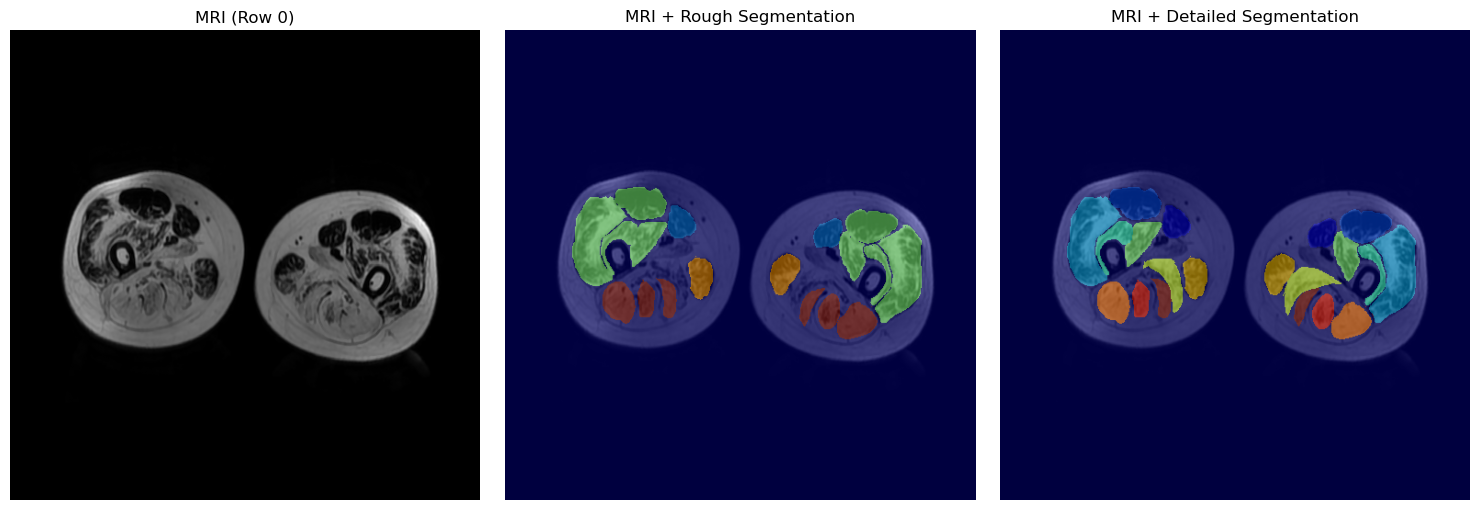

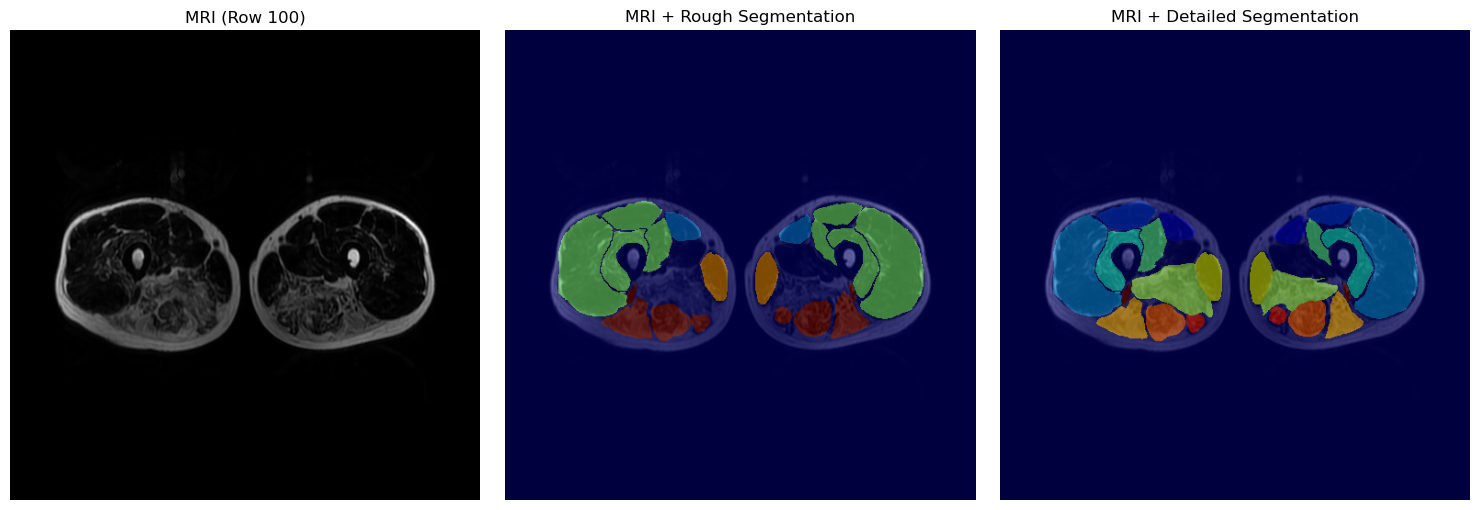

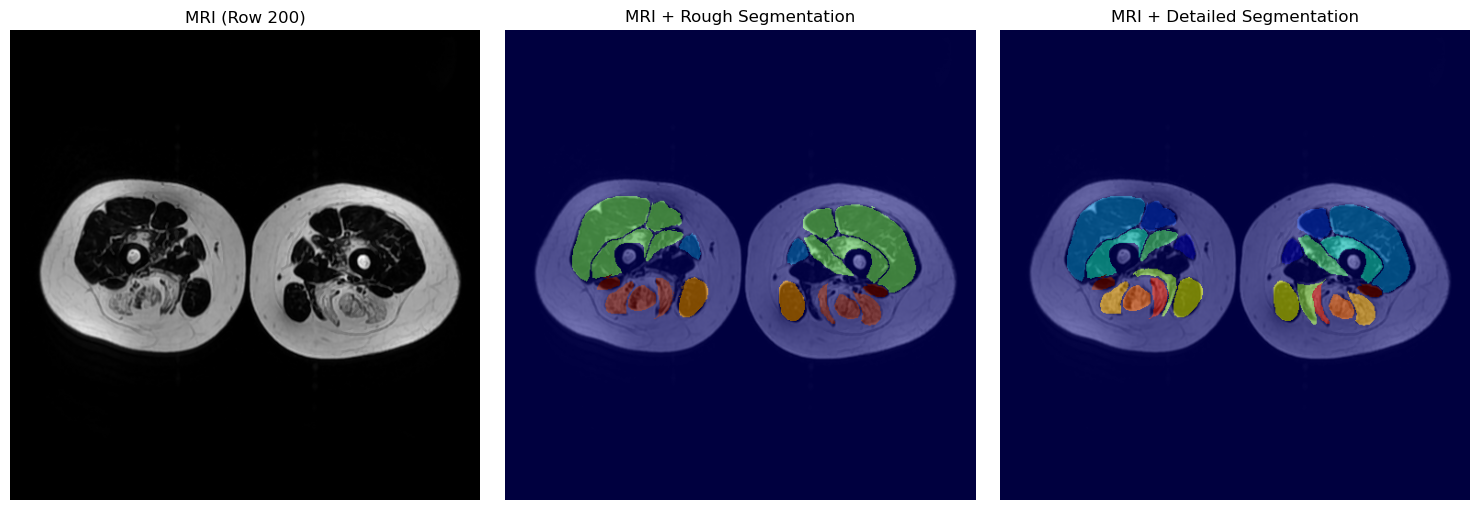

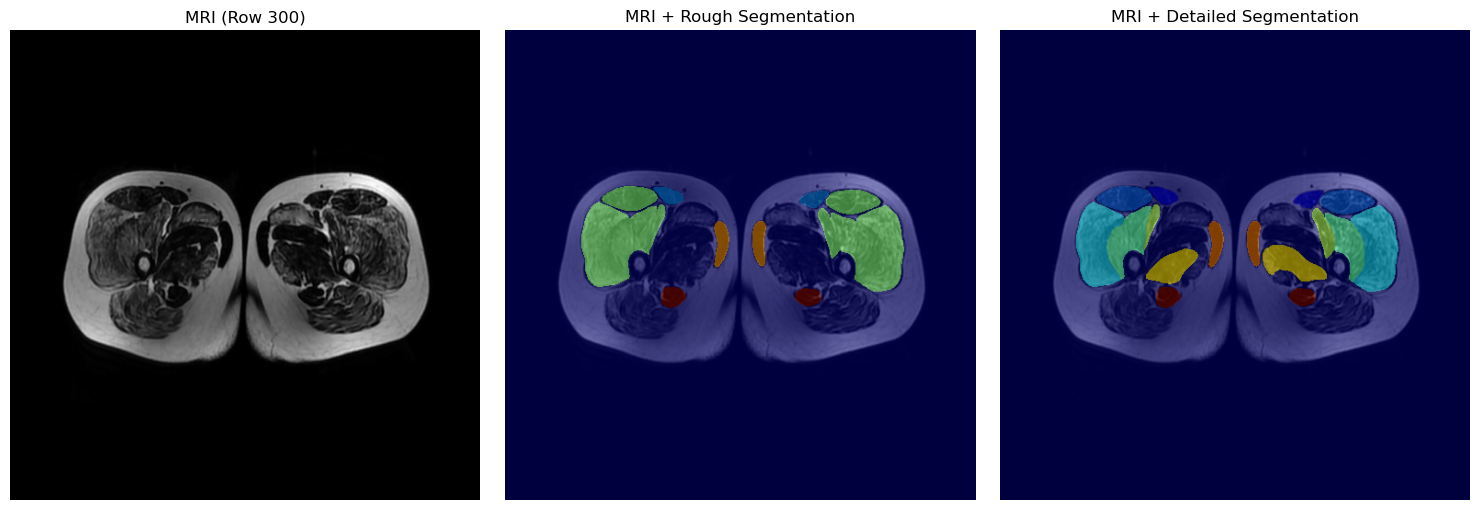

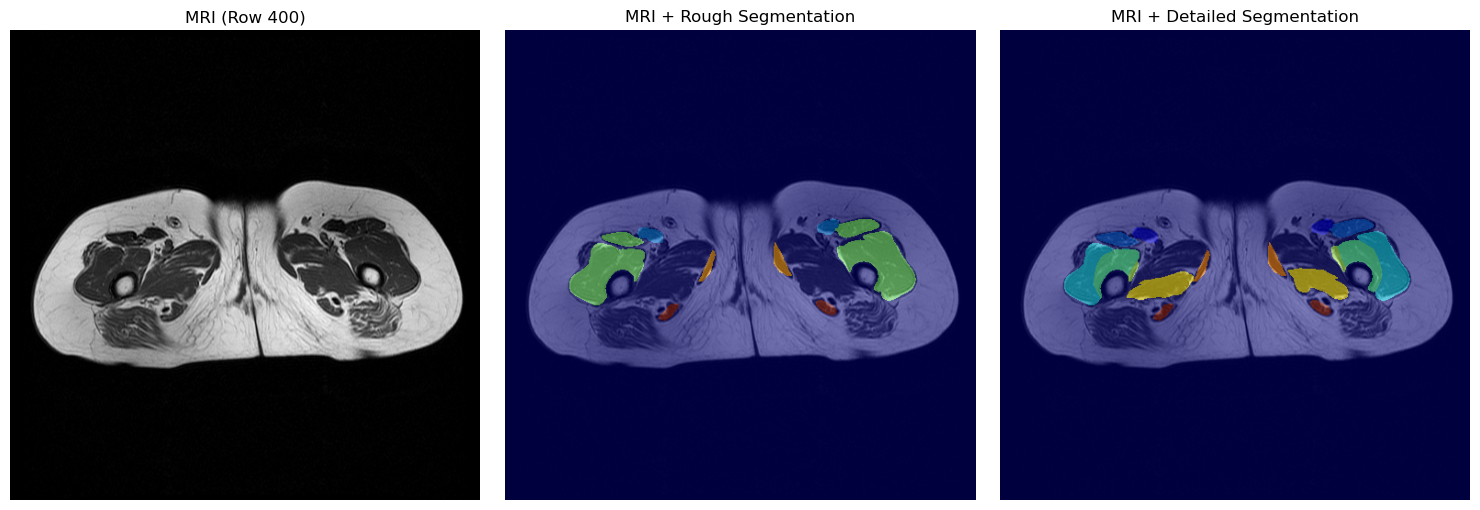

In [58]:
import os
import SimpleITK as sitk
import matplotlib.pyplot as plt
import numpy as np

for index, row in metadata_3D_df.iterrows():
    image_path = os.path.join(root_dir, row['image_3D_file'])
    rough_label_3D_file = os.path.join(root_dir, row['rough_label_3D_file'])

    if not os.path.exists(image_path):
        print(f"Image file not found: {image_path}")
    if not os.path.exists(rough_label_3D_file):
        print(f"Segmentation file not found: {rough_label_3D_file}")

    if row['detailed_label_3D_file'] is None:
        continue
    detailed_label_3D_file = os.path.join(root_dir, row['detailed_label_3D_file'])
    if not os.path.exists(detailed_label_3D_file):
        print(f"Detailed Segmentation file not found: {detailed_label_3D_file}")
        
    if index%100==0:
        image = sitk.ReadImage(image_path)
        rough_label = sitk.ReadImage(rough_label_3D_file)
        detailed_label = sitk.ReadImage(detailed_label_3D_file)

        image_array = sitk.GetArrayFromImage(image)
        rough_label_array = sitk.GetArrayFromImage(rough_label)
        detailed_label_array = sitk.GetArrayFromImage(detailed_label)

        z_middle = image_array.shape[0] // 2
        image_slice = image_array[z_middle, :, :]
        rough_label_slice = rough_label_array[z_middle, :, :]
        detailed_label_slice = detailed_label_array[z_middle, :, :]

        fig, axs = plt.subplots(1, 3, figsize=(15, 5))

        axs[0].imshow(image_slice, cmap='gray')
        axs[0].set_title(f'MRI (Row {index})')
        axs[0].axis('off')

        axs[1].imshow(image_slice, cmap='gray')
        axs[1].imshow(rough_label_slice, cmap='jet', alpha=0.5) 
        axs[1].set_title('MRI + Rough Segmentation')
        axs[1].axis('off')

        axs[2].imshow(image_slice, cmap='gray')
        axs[2].imshow(detailed_label_slice, cmap='jet', alpha=0.5)
        axs[2].set_title('MRI + Detailed Segmentation')
        axs[2].axis('off')

        plt.tight_layout()
        plt.show()

## 2D dataset

In [59]:
import pandas as pd

output_csv_path = os.path.join(root_dir, "metadata_3D.csv")
metadata_3D_df = pd.read_csv(output_csv_path)

display(metadata_3D_df)
print(metadata_3D_df.columns)

Dataset MRI sample Phenotype    Ethnicity Gender Age MRI Sequence  \
0      HuashanMyo  THIGH_001    LGMDR1  Han Chinese      M  29          Fat   
1      HuashanMyo  THIGH_001    LGMDR1  Han Chinese      M  29          Fat   
2      HuashanMyo  THIGH_001    LGMDR1  Han Chinese      M  29         STIR   
3      HuashanMyo  THIGH_001    LGMDR1  Han Chinese      M  29           T1   
4      HuashanMyo  THIGH_001    LGMDR1  Han Chinese      M  29           T2   
..            ...        ...       ...          ...    ...  ..          ...   
570  MyoSegmenTUM     P004_1       DM2      Germans      F  66  FATFRACTION   
571  MyoSegmenTUM     P004_1       DM2      Germans      F  66  FATFRACTION   
572  MyoSegmenTUM     P004_1       DM2      Germans      F  66        WATER   
573  MyoSegmenTUM     P004_1       DM2      Germans      F  66        WATER   
574  MyoSegmenTUM     P004_1       DM2      Germans      F  66        WATER   

                                         image_3D_file  \
0        3D_dataset/train/image/0_THIGH_001_Fat.nii.gz   
1        3D_dataset/train/image/1_THIGH_001_Fat.nii.gz   
2       3D_dataset/train/image/2_THIGH_001_STIR.nii.gz   
3         3D_dataset/train/image/3_THIGH_001_T1.nii.gz   
4         3D_dataset/train/image/4_THIGH_001_T2.nii.gz   
..                                                 ...   
570  3D_dataset/train/image/570_P004_1_FATFRACTION....   
571  3D_dataset/train/image/571_P004_1_FATFRACTION....   
572     3D_dataset/train/image/572_P004_1_WATER.nii.gz   
573     3D_dataset/train/image/573_P004_1_WATER.nii.gz   
574     3D_dataset/train/image/574_P004_1_WATER.nii.gz   

                                   rough_label_3D_file  \
0    3D_dataset/train/rough_label/0_THIGH_001_Fat_r...   
1    3D_dataset/train/rough_label/1_THIGH_001_Fat_r...   
2    3D_dataset/train/rough_label/2_THIGH_001_STIR_...   
3    3D_dataset/train/rough_label/3_THIGH_001_T1_ro...   
4    3D_dataset/train/rough_label/4_THIGH_001_T2_ro...   
..                                                 ...   
570  3D_dataset/train/rough_label/570_P004_1_FATFRA...   
571  3D_dataset/train/rough_label/571_P004_1_FATFRA...   
572  3D_dataset/train/rough_label/572_P004_1_WATER_...   
573  3D_dataset/train/rough_label/573_P004_1_WATER_...   
574  3D_dataset/train/rough_label/574_P004_1_WATER_...   

                                detailed_label_3D_file  split  
0    3D_dataset/train/detailed_label/0_THIGH_001_Fa...  train  
1    3D_dataset/train/detailed_label/1_THIGH_001_Fa...  train  
2    3D_dataset/train/detailed_label/2_THIGH_001_ST...  train  
3    3D_dataset/train/detailed_label/3_THIGH_001_T1...  train  
4    3D_dataset/train/detailed_label/4_THIGH_001_T2...  train  
..                                                 ...    ...  
570                                                NaN  train  
571                                                NaN  train  
572                                                NaN  train  
573                                                NaN  train  
574                                                NaN  train  

[575 rows x 11 columns]

Index(['Dataset', 'MRI sample', 'Phenotype', 'Ethnicity', 'Gender', 'Age',
       'MRI Sequence', 'image_3D_file', 'rough_label_3D_file',
       'detailed_label_3D_file', 'split'],
      dtype='object')


In [60]:
import os

folders = [
    os.path.join(root_dir, "2D_dataset", "train", "image"),
    os.path.join(root_dir, "2D_dataset", "train", "rough_label"),
    os.path.join(root_dir, "2D_dataset", "train", "detailed_label"),
    os.path.join(root_dir, "2D_dataset", "test", "image"),
    os.path.join(root_dir, "2D_dataset", "test", "rough_label"),
    os.path.join(root_dir, "2D_dataset", "test", "detailed_label"),
]

for folder in folders:
    os.makedirs(folder, exist_ok=True)
    print(f"已建立資料夾: {folder}")

已建立資料夾: /gpfs/home/pl2948/CV/Project/data/2D_dataset/train/image
已建立資料夾: /gpfs/home/pl2948/CV/Project/data/2D_dataset/train/rough_label
已建立資料夾: /gpfs/home/pl2948/CV/Project/data/2D_dataset/train/detailed_label
已建立資料夾: /gpfs/home/pl2948/CV/Project/data/2D_dataset/test/image
已建立資料夾: /gpfs/home/pl2948/CV/Project/data/2D_dataset/test/rough_label
已建立資料夾: /gpfs/home/pl2948/CV/Project/data/2D_dataset/test/detailed_label


In [61]:
import SimpleITK as sitk
import os
from tqdm import tqdm

metadata_2D = []

for index, row in tqdm(metadata_3D_df.iterrows(), total=metadata_3D_df.shape[0]):
    split = row['split']
    dataset = row['Dataset']
    mri_sample = row['MRI sample']
    phenotype = row['Phenotype']
    ethnicity = row['Ethnicity']
    gender = row['Gender']
    age = row['Age']
    mri_sequence = row['MRI Sequence']

    image_src_path = os.path.join(root_dir, row['image_3D_file'])
    rough_label_src_path = os.path.join(root_dir, row['rough_label_3D_file'])
    if pd.notna(row['detailed_label_3D_file']):
        detailed_label_src_path = os.path.join(root_dir, row['detailed_label_3D_file'])

    image = sitk.ReadImage(image_src_path)
    rough_label = sitk.ReadImage(rough_label_src_path)
    detailed_label = sitk.ReadImage(detailed_label_src_path)

    image_array = sitk.GetArrayFromImage(image)
    rough_label_array = sitk.GetArrayFromImage(rough_label)
    detailed_label_array = sitk.GetArrayFromImage(detailed_label)

    for z in range(image_array.shape[0]):
        image_slice = image_array[z, :, :]
        rough_label_slice = rough_label_array[z, :, :]
        if pd.notna(row['detailed_label_3D_file']):
            detailed_label_slice = detailed_label_array[z, :, :]

        if np.any(rough_label_slice):
            image_dst_path = os.path.join(root_dir, "2D_dataset", split, "image", f"{index}_{z}_{row['MRI sample']}_{row['MRI Sequence']}.nii.gz")
            rough_label_dst_path = os.path.join(root_dir, "2D_dataset", split, "rough_label", f"{index}_{z}_{row['MRI sample']}_{row['MRI Sequence']}_rough.nii.gz")
            detailed_label_dst_path = os.path.join(root_dir, "2D_dataset", split, "detailed_label", f"{index}_{z}_{row['MRI sample']}_{row['MRI Sequence']}_detailed.nii.gz")

            image_2D_file = os.path.join("2D_dataset", split, "image", f"{index}_{z}_{mri_sample}_{mri_sequence}.nii.gz")
            rough_label_2D_file = os.path.join("2D_dataset", split, "rough_label", f"{index}_{z}_{mri_sample}_{mri_sequence}_rough.nii.gz")
            detailed_label_2D_file = os.path.join("2D_dataset", split, "detailed_label", f"{index}_{z}_{mri_sample}_{mri_sequence}_detailed.nii.gz")

            sitk.WriteImage(sitk.GetImageFromArray(image_slice), image_dst_path)
            sitk.WriteImage(sitk.GetImageFromArray(rough_label_slice), rough_label_dst_path)
            if pd.notna(row['detailed_label_3D_file']):
                sitk.WriteImage(sitk.GetImageFromArray(detailed_label_slice), detailed_label_dst_path)

            metadata_2D.append({
                'Dataset': dataset,
                'MRI sample': mri_sample,
                'Phenotype': phenotype,
                'Ethnicity': ethnicity,
                'Gender': gender,
                'Age': age,
                'MRI Sequence': mri_sequence,
                'Slice': z,
                'image_2D_file': image_2D_file,
                'rough_label_2D_file': rough_label_2D_file,
                'detailed_label_2D_file': detailed_label_2D_file,
                'split': split
            })

metadata_2D_df = pd.DataFrame(metadata_2D)

metadata_2D_df.loc[metadata_2D_df['Dataset']=='MyoSegmenTUM', 'detailed_label_2D_file'] = None

output_csv_path = os.path.join(root_dir, "metadata_2D.csv")
metadata_2D_df.to_csv(output_csv_path, index=False)

print(f"新的 metadata_2D 已儲存至 {output_csv_path}")

100%|██████████| 575/575 [15:48<00:00,  1.65s/it]

新的 metadata_2D 已儲存至 /gpfs/home/pl2948/CV/Project/data/metadata_2D.csv


In [62]:
metadata_2D_df

Dataset MRI sample Phenotype    Ethnicity Gender Age MRI Sequence  \
0        HuashanMyo  THIGH_001    LGMDR1  Han Chinese      M  29          Fat   
1        HuashanMyo  THIGH_001    LGMDR1  Han Chinese      M  29          Fat   
2        HuashanMyo  THIGH_001    LGMDR1  Han Chinese      M  29          Fat   
3        HuashanMyo  THIGH_001    LGMDR1  Han Chinese      M  29          Fat   
4        HuashanMyo  THIGH_001    LGMDR1  Han Chinese      M  29          Fat   
...             ...        ...       ...          ...    ...  ..          ...   
13614  MyoSegmenTUM     P004_1       DM2      Germans      F  66        WATER   
13615  MyoSegmenTUM     P004_1       DM2      Germans      F  66        WATER   
13616  MyoSegmenTUM     P004_1       DM2      Germans      F  66        WATER   
13617  MyoSegmenTUM     P004_1       DM2      Germans      F  66        WATER   
13618  MyoSegmenTUM     P004_1       DM2      Germans      F  66        WATER   

       Slice                                      image_2D_file  \
0          0    2D_dataset/train/image/0_0_THIGH_001_Fat.nii.gz   
1          1    2D_dataset/train/image/0_1_THIGH_001_Fat.nii.gz   
2          2    2D_dataset/train/image/0_2_THIGH_001_Fat.nii.gz   
3          3    2D_dataset/train/image/0_3_THIGH_001_Fat.nii.gz   
4          4    2D_dataset/train/image/0_4_THIGH_001_Fat.nii.gz   
...      ...                                                ...   
13614     25  2D_dataset/train/image/574_25_P004_1_WATER.nii.gz   
13615     26  2D_dataset/train/image/574_26_P004_1_WATER.nii.gz   
13616     27  2D_dataset/train/image/574_27_P004_1_WATER.nii.gz   
13617     28  2D_dataset/train/image/574_28_P004_1_WATER.nii.gz   
13618     29  2D_dataset/train/image/574_29_P004_1_WATER.nii.gz   

                                     rough_label_2D_file  \
0      2D_dataset/train/rough_label/0_0_THIGH_001_Fat...   
1      2D_dataset/train/rough_label/0_1_THIGH_001_Fat...   
2      2D_dataset/train/rough_label/0_2_THIGH_001_Fat...   
3      2D_dataset/train/rough_label/0_3_THIGH_001_Fat...   
4      2D_dataset/train/rough_label/0_4_THIGH_001_Fat...   
...                                                  ...   
13614  2D_dataset/train/rough_label/574_25_P004_1_WAT...   
13615  2D_dataset/train/rough_label/574_26_P004_1_WAT...   
13616  2D_dataset/train/rough_label/574_27_P004_1_WAT...   
13617  2D_dataset/train/rough_label/574_28_P004_1_WAT...   
13618  2D_dataset/train/rough_label/574_29_P004_1_WAT...   

                                  detailed_label_2D_file  split  
0      2D_dataset/train/detailed_label/0_0_THIGH_001_...  train  
1      2D_dataset/train/detailed_label/0_1_THIGH_001_...  train  
2      2D_dataset/train/detailed_label/0_2_THIGH_001_...  train  
3      2D_dataset/train/detailed_label/0_3_THIGH_001_...  train  
4      2D_dataset/train/detailed_label/0_4_THIGH_001_...  train  
...                                                  ...    ...  
13614                                               None  train  
13615                                               None  train  
13616                                               None  train  
13617                                               None  train  
13618                                               None  train  

[13619 rows x 12 columns]

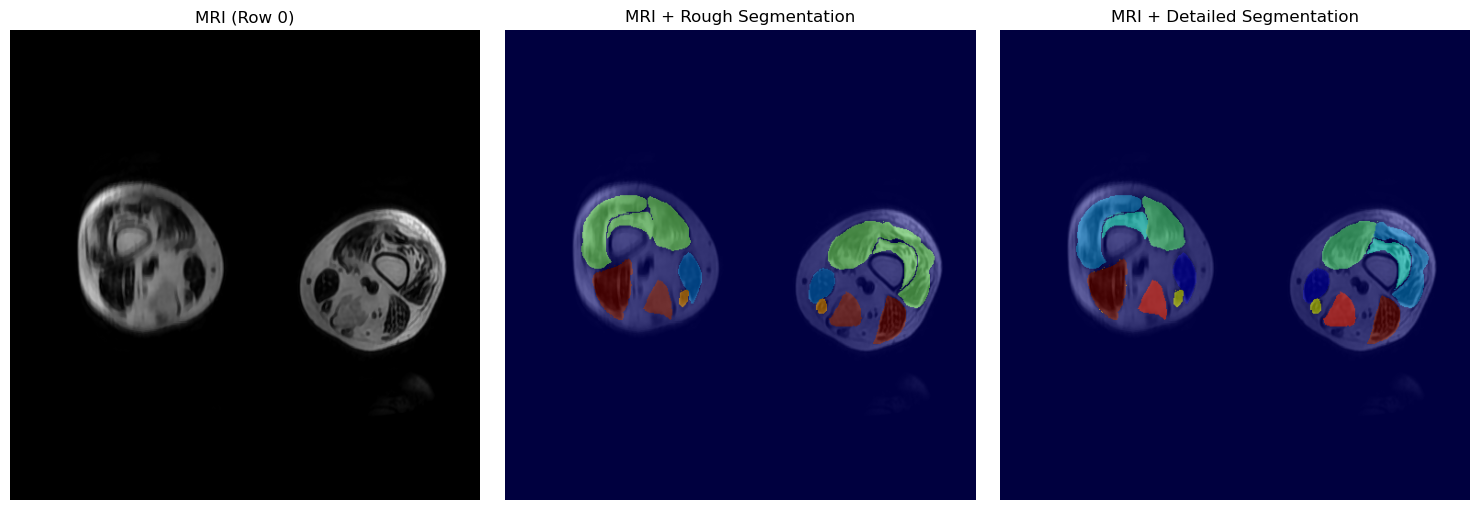

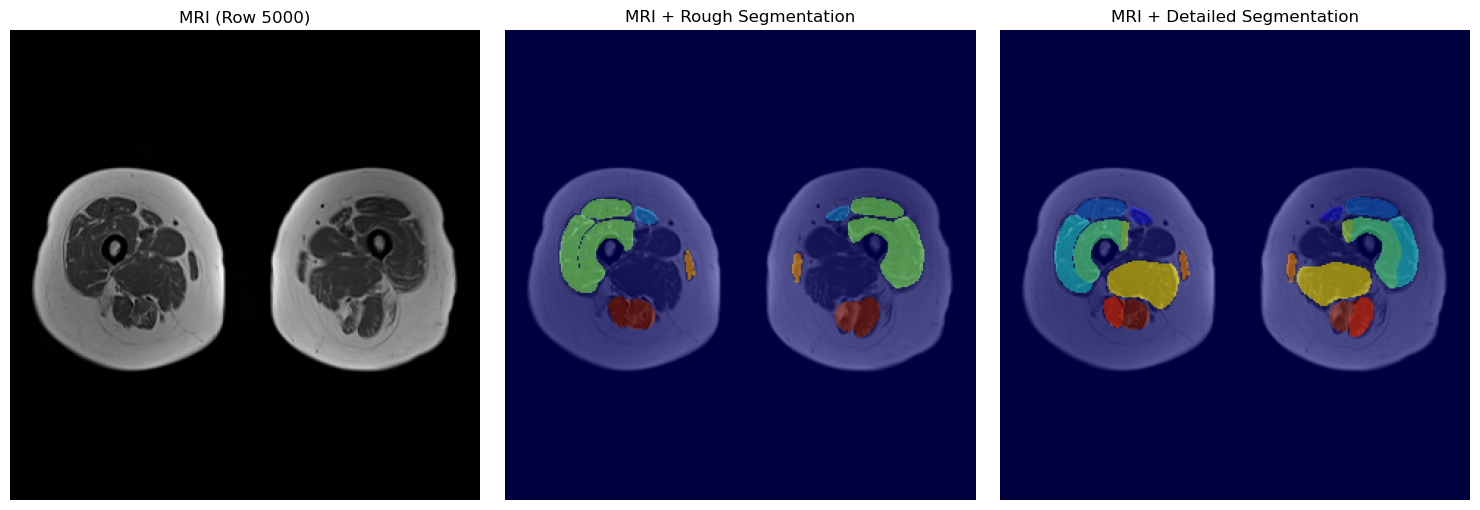

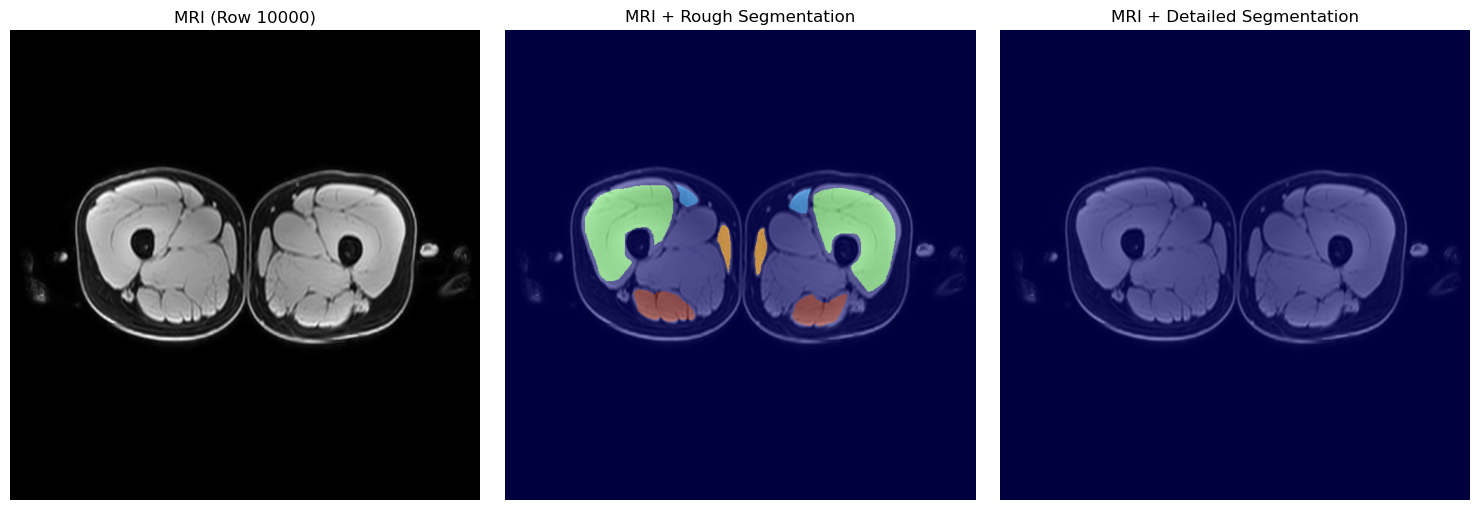

In [63]:
import os
import SimpleITK as sitk
import matplotlib.pyplot as plt
import numpy as np

for index, row in metadata_2D_df.iterrows():
    image_path = os.path.join(root_dir, row['image_2D_file'])
    rough_label_2D_file = os.path.join(root_dir, row['rough_label_2D_file'])

    if not os.path.exists(image_path):
        print(f"Image file not found: {image_path}")
    if not os.path.exists(rough_label_2D_file):
        print(f"Segmentation file not found: {rough_label_2D_file}")

    if pd.notna(row['detailed_label_2D_file']):
        detailed_label_2D_file = os.path.join(root_dir, row['detailed_label_2D_file'])
        if not os.path.exists(detailed_label_2D_file):
            print(f"Detailed Segmentation file not found: {detailed_label_2D_file}")
    else: 
        detailed_label_2D_file = None
        
    if index%5000==0:
        image = sitk.ReadImage(image_path)
        rough_label = sitk.ReadImage(rough_label_2D_file)

        image_slice = sitk.GetArrayFromImage(image)
        rough_label_slice = sitk.GetArrayFromImage(rough_label)

        if detailed_label_2D_file is not None:
            detailed_label = sitk.ReadImage(detailed_label_2D_file)
            detailed_label_slice = sitk.GetArrayFromImage(detailed_label)
        else:
            detailed_label = None
            detailed_label_slice = np.zeros(sitk.GetArrayFromImage(image).shape, dtype=np.uint8)

        fig, axs = plt.subplots(1, 3, figsize=(15, 5))

        axs[0].imshow(image_slice, cmap='gray')
        axs[0].set_title(f'MRI (Row {index})')
        axs[0].axis('off')

        axs[1].imshow(image_slice, cmap='gray')
        axs[1].imshow(rough_label_slice, cmap='jet', alpha=0.5) 
        axs[1].set_title('MRI + Rough Segmentation')
        axs[1].axis('off')

        axs[2].imshow(image_slice, cmap='gray')
        axs[2].imshow(detailed_label_slice, cmap='jet', alpha=0.5)
        axs[2].set_title('MRI + Detailed Segmentation')
        axs[2].axis('off')

        plt.tight_layout()
        plt.show()